# Plot results from different runs

## Setup

In [1]:
import os, sys, itertools, functools
import warnings
from collections import ChainMap
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.externals import joblib
from scipy import stats
import matplotlib
matplotlib.use("pdf")
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
sys.path.append('..')
from src.MLA import calc_metrics, q2_f3_score
%matplotlib inline


In [2]:
def expand_inner_arrs(ser):
    return ser.apply(lambda x: pd.Series(np.ravel(x))).stack()

def expand_inner_arrs_faster(ser, level="dataset"):
    idxs = ser.index.levels[ser.index.names.index(level)]
    result = {}
    for idx in idxs:
        result[idx] = expand_inner_arrs(ser.xs(idx, level=level))
    return pd.concat(result, names=[level])

def filter_equal(col_name, value):
    def inner(df):
        return df[col_name] == value
    return inner

def filter_notequal(col_name, value):
    def inner(df):
        return df[col_name] != value
    return inner

def filter_in(col_name, values):
    def inner(df):
        return df[col_name].isin(values)
    return inner

def filter_notin(col_name, values):
    def inner(df):
        return ~df[col_name].isin(values)
    return inner

def filter_greater(col_name, value):
    def inner(df):
        return df[col_name] > value
    return inner

def filter_greaterequal(col_name, value):
    def inner(df):
        return df[col_name] >= value
    return inner

def filter_less(col_name, value):
    def inner(df):
        return df[col_name] < value
    return inner

def filter_lessequal(col_name, value):
    def inner(df):
        return df[col_name] <= value
    return inner

def filter_between(col_name, lower, upper):
    def inner(df):
        return (df[col_name] >= lower) & (df[col_name] <= upper)
    return inner

In [3]:
def texify_val_error(values, nan_text="NA", sig_digits=2, force_sig=False):
    nan_check = pd.isna(values)
    if nan_check[0]:
        return nan_text
    elif nan_check[1] or values[1] == 0:
        return "{{:.{}f}}".format(sig_digits).format(values[0])
    else:
        error = "{:.1g}".format(values[1])
        split_error = error.split(".")
        if len(split_error) == 2:
            sig = len(split_error[1])
            if force_sig:
                sig = min(sig, sig_digits)                    
            value = '{{:.{prec}f}}'.format(prec=sig).format(values[0])
            error = '{{:.{prec}f}}'.format(prec=sig).format(values[1])
        else:
            error = str(round(values[1]))
            value = str(round(values[0]))
        return "\\num{{{} \\pm {}}}".format(value, error)


def texify_df_groupby(df, axis=1, stats=('mean', 'std'), force_sig=False):
    trans_func=None
    if force_sig:
        trans_func = functools.partial(texify_val_error, force_sig=True)
    else:
        trans_func = texify_val_error
    result = (df.agg([*stats])
         .groupby(axis=axis, level=0).transform(trans_func)
         .xs("mean", axis=axis, level=1)
         )
    return result

## Settings

In [4]:
datapath = Path("../../../run_outputs").resolve()

runpaths = {
             'de_rotb': 'raspdata_200503_180444/',
             'mw_only': 'raspdata_200503_171525/',
             'molecule_only': 'raspdata_200503_170528/',
             'protein_only': 'raspdata_200503_170217/',
             'mr_only': 'raspdata_200503_171023/',
}

runpaths = {name: datapath / path for name, path in runpaths.items()}

all_dataset_names={'BACE_Protein_Ligand_Parameter' : 'BACE',
       'CDK2-CyclinA_Protein_Ligand_Parameter': 'CDK2-Cyclin A',
       'CDK2-Kinase_Protein_Ligand_Parameter': 'CDK2 Kinase',
       'CDK2_Protein_Ligand_Parameter': 'CDK2',
       'CHK1-Kinase_Protein_Ligand_Parameter': 'CHK1 Kinase',
       'ERK2_Protein_Ligand_Parameter': 'ERK2', 
                   'HSP90_Protein_Ligand_Parameter': 'HSP90',
       'LpxC_Protein_Ligand_Parameter': 'LpxC', 
                   'Mcl-1_Protein_Ligand_Parameter': 'Mcl-1',
       'Mcl-all_Protein_Ligand_Parameter': 'Mcl-1 all', 
                   'P38_Protein_Ligand_Parameter': 'p38',
       'PTP1B_Protein_Ligand_Parameter': "PTP1B", 
                   'Parameter_HiQ_Set1_55complexes': "CSAR HiQ 1",
       'Parameter_HiQ_Set2_47complexes': "CSAR HiQ 2", 
                   'SYK_Protein_Ligand_Parameter': "SYK",
       'TYK2_Protein_Ligand_Parameter': "TYK2",
       'TYK2_all_Protein_Ligand_Parameter': "TYK2 all",
       'Thrombin_Protein_Ligand_Parameter': "Thrombin",
       'TrmD_Protein_Ligand_Parameter': "TrmD",
       'Urokinase_Protein_Ligand_Parameter': "Urokinase"}

dataset_sets = {
    "CSAR12":("CDK2-Cyclin A", "CDK2 Kinase", "CHK1 Kinase", 
              "ERK2", "LpxC", "Urokinase"),
    "CSAR14":("SYK", "TrmD", "HSP90"),
    "CSAR HiQ": ("CSAR HiQ 1", "CSAR HiQ 2"),
    "Wang":("BACE", "CDK2", "Mcl-1 all", "p38", "PTP1B", "Thrombin", "TYK2 all"),
    "D3R":("CDK2-Cyclin A", "CDK2 Kinase", "CHK1 Kinase", "ERK2", "LpxC", "Urokinase","SYK", "TrmD", "HSP90"),
}

model_renamer = {
     'Epsilon-Support Vector Regression': "SVR",
     'Extremely Random Forest': "eRF",
     'LinearRegression': "LR",
     'Mean of training set': "null model",
     'Nearest-Neighbor': "kNN",
     'RASPDeep': "DNN",
     'Random Forest': "RF",
     'Support Vector Regression':"lSVR"
}

ds_arr_names = {"y_train": "training", "y_val": "validation", "y_test": "test"}

metric_idx_cols = ["run", "dataset", "model", "replicate", "fold"]
metric_met_cols = ['mean_squared_error', 'median_absolute_error', 'RMSE', 'r_pearson',
       'r_spearman', 'r2_score', 'Q2_F3', 'time']

fi_idx_cols = ["run", "dataset", "model", "replicate", "fold", "permutation", "feature"]
fi_met_cols = ['mean_squared_error', 'median_absolute_error', 'r_spearman',
       'r_pearson', 'r2_score', 'Q2_F3']

out = datapath / "plots"
out.mkdir(exist_ok=True)


model_order = ["eRF", "RF", "DNN", "SVR", "lSVR","kNN", "LR", "null model"]
metrics_order = ["median_absolute_error", "RMSE", "r_pearson", "r_spearman", "r2_score", "Q2_F3"]
ignored_metrics = ["mean_squared_error", "median_absolute_error", "time"]

feature_renamer = {'P': 'logP', 'Volume': 'PVol', 'PP(Arom)': 'PlogP(Arom)', 'PP(Non-Arom)': 'PlogP(Non-Arom)', 
                   'PA (D+E)': 'PA(D+E)', 'PMR (Arom)': 'PMR(Arom)'}
ligand_order = ['A', 'D', 'logP', 'W', 'MR', 'MASS']
protein_order = ['PA(D+E)',
                 'PA(N+Q+T+S+DH+EH)',
                 'PA(Y+H)',
                 'PD(K+R+HIP)',
                 'PD(LYN+N+Q)',
                 'PD(T+S+Y+DH+EH)',
                 'PD(W+H)',
                 'PA(Amide-O)',
                 'PD(Amide-NH)',
                 'PlogP(Arom)',
                 'PlogP(Non-Arom)',
                 'PMR(Arom)',
                 'PMR(Non-Arom)',
                 'PVol']
feature_order = protein_order + ligand_order

In [5]:
feature_order

['PA(D+E)',
 'PA(N+Q+T+S+DH+EH)',
 'PA(Y+H)',
 'PD(K+R+HIP)',
 'PD(LYN+N+Q)',
 'PD(T+S+Y+DH+EH)',
 'PD(W+H)',
 'PA(Amide-O)',
 'PD(Amide-NH)',
 'PlogP(Arom)',
 'PlogP(Non-Arom)',
 'PMR(Arom)',
 'PMR(Non-Arom)',
 'PVol',
 'A',
 'D',
 'logP',
 'W',
 'MR',
 'MASS']

In [6]:
style_base = {"savefig.dpi": 600,
              "savefig.bbox": "standard",
         "figure.autolayout": True,
         "font.style": "normal",
         "font.size": 7,
         "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 2,
          "lines.linewidth": 1,
  "legend.frameon": "False",
              "xtick.labelsize": 6,
              "ytick.labelsize": 6,
  "xtick.direction": "out",
  "xtick.major.size": 4,
  "xtick.major.width": 1,
  "xtick.minor.size": 1,
  "xtick.minor.width": 1,
  "ytick.direction": "out",
  "ytick.major.size": 4,
  "ytick.major.width": 1,
  "ytick.minor.size": 1,
  "ytick.minor.width": 1}



## Load and check

In [7]:
metric_dfs = {}
fi_dfs = {}
raw_preds = {}
dss = {key: {} for key in ds_arr_names.values()}
best_hypers = {}
for run, path in runpaths.items():
    metric_dfs[run] = pd.read_csv(path / "all_metrics.tsv", sep="\t", 
                                  dtype={"dataset": "category", "model":"category"})
    try:
        fi_dfs[run] = pd.read_csv(path / "feature_importances.tsv", sep="\t", 
                                  dtype={"dataset": "category", "model":"category"})
    except FileNotFoundError:
        pass
    raw_preds[run] = joblib.load(path / "raw_predictions.joblib")
    
    for fname, name in ds_arr_names.items():
        try:
            dat = np.load(path / f"{fname}.npy")
        
            dfs = {}
            for n_shuffle, shuffle in enumerate(dat):
                if name == "test":
                    dfs[n_shuffle] = pd.DataFrame(shuffle, columns=["Expt_BE", "Atom_Efficiency"])
                else:
                    dfs[n_shuffle] = {}
                    for n_f, fold in enumerate(shuffle):
                        dfs[n_shuffle][n_f] = pd.DataFrame(fold, columns=["Expt_BE", "Atom_Efficiency"])
                    dfs[n_shuffle] = pd.concat(dfs[n_shuffle], names=["fold"])
            dss[name][run] = pd.concat(dfs, names=["replicate"])
        except FileNotFoundError:
            pass
    try:
        best_hypers[run] = pd.read_table(path / "hyper.tsv").rename(columns=model_renamer)
    except FileNotFoundError:
        pass

In [8]:
all_metrics = pd.concat(metric_dfs, names=["run"], sort=False).reset_index(level="run")
all_metrics["model"] = all_metrics.model.cat.rename_categories(model_renamer)
all_fis = pd.concat(fi_dfs, names=["run"], sort=False).reset_index(level="run")
all_fis["model"] = all_fis.model.cat.rename_categories(model_renamer)
all_fis["feature"] = all_fis['feature'].replace(feature_renamer)

all_preds = (pd.concat(raw_preds, names=["run"], sort=False)
             .rename(index=all_dataset_names, level="dataset")
             .rename(index=model_renamer, level="model"))
all_ds_sizes = all_preds.transform(len)
pdbbind_ds = {key: pd.concat(value, names=["run"]) for key, value in dss.items()}

In [9]:
del metric_dfs
del raw_preds
del fi_dfs
del dss

In [10]:
all_metrics_tidy = all_metrics.melt(id_vars=metric_idx_cols, 
                                                  value_vars=metric_met_cols, 
                                                  var_name="metric", value_name="value" )\
                                                .replace({"dataset":all_dataset_names})
all_fis_tidy = all_fis.melt(id_vars=fi_idx_cols, value_vars=fi_met_cols, 
                                                  var_name="metric", value_name="value" )\
                                                .replace({"dataset":all_dataset_names})

In [13]:
external_path = Path("../../../external_test_sets/").resolve()
external_datasets = {}

In [14]:
for file in external_path.iterdir():
    df = pd.read_csv(file, sep=";")[["PDBID", "Expt_BE", "Atom_Efficiency"]].set_index("PDBID")
    fname = file.name[:-4]
    external_datasets[all_dataset_names[fname]] = df

In [15]:
external_datasets = pd.concat(external_datasets, names=["dataset"])

### Checks

In [16]:
all_metrics_tidy.head()

,run,dataset,model,replicate,fold,metric,value
0,de_rotb,BACE,SVR,0,0,mean_squared_error,1.366808
1,de_rotb,BACE,SVR,0,1,mean_squared_error,1.438835
2,de_rotb,BACE,SVR,0,2,mean_squared_error,1.595614
3,de_rotb,BACE,SVR,0,3,mean_squared_error,1.467422
4,de_rotb,BACE,SVR,0,4,mean_squared_error,1.541557


In [17]:
all_fis_tidy.head()

,run,dataset,model,replicate,fold,permutation,feature,metric,value
0,de_rotb,training,null model,0,0,0,PD(K+R+HIP),mean_squared_error,0.0
1,de_rotb,training,null model,0,0,1,PD(K+R+HIP),mean_squared_error,0.0
2,de_rotb,training,null model,0,0,2,PD(K+R+HIP),mean_squared_error,0.0
3,de_rotb,training,null model,0,0,3,PD(K+R+HIP),mean_squared_error,0.0
4,de_rotb,training,null model,0,0,4,PD(K+R+HIP),mean_squared_error,0.0


In [18]:
model_names = [*all_metrics_tidy.model.unique()]
model_names

['SVR', 'eRF', 'LR', 'null model', 'kNN', 'DNN', 'RF', 'lSVR']

## Hyperparams overview

In [19]:
for model in model_names: 
    print("="*40)
    print(model)
    print(best_hypers["de_rotb"].groupby(model)[model].count())

SVR
SVR
(<class 'sklearn.svm.classes.SVR'>, {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'})    10
Name: SVR, dtype: int64
eRF
eRF
(<class 'sklearn.ensemble.forest.ExtraTreesRegressor'>, {'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 100})    1
(<class 'sklearn.ensemble.forest.ExtraTreesRegressor'>, {'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 200})    8
(<class 'sklearn.ensemble.forest.ExtraTreesRegressor'>, {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200})    1
Name: eRF, dtype: int64
LR
LR
(<class 'sklearn.linear_model.base.LinearRegression'>, {})    10
Name: LR, dtype: int64
null model
null model
(<class 'sklearn.dummy.DummyRegressor'>, {})    10
Name: null model, dtype: int64
kNN
kNN
(<class 'sklearn.neighbors.regression.KNeighborsRegressor'>, {'n_neighbors': 10})    1
(<class 'sklearn.neighbors.regression.KNeighborsRegressor'>, {'n_neighbors': 5})     9
Name: kNN, dtype: int64
DNN
DNN
round_epochs                    71\nval_loss 

## Overview internal

In [20]:
all_metrics.groupby(["run", "dataset", "model"]).agg(["mean", "std"])

replicate  \
                                                                   mean   
run          dataset                               model                  
de_rotb      BACE_Protein_Ligand_Parameter         SVR              4.5   
                                                   eRF              4.5   
                                                   LR               4.5   
                                                   null model       4.5   
                                                   kNN              4.5   
                                                   DNN              4.5   
                                                   RF               4.5   
                                                   lSVR             4.5   
             CDK2-CyclinA_Protein_Ligand_Parameter SVR              4.5   
                                                   eRF              4.5   
                                                   LR               4.5   
                                                   null model       4.5   
                                                   kNN              4.5   
                                                   DNN              4.5   
                                                   RF               4.5   
                                                   lSVR             4.5   
             CDK2-Kinase_Protein_Ligand_Parameter  SVR              4.5   
                                                   eRF              4.5   
                                                   LR               4.5   
                                                   null model       4.5   
                                                   kNN              4.5   
                                                   DNN              4.5   
                                                   RF               4.5   
                                                   lSVR             4.5   
             CDK2_Protein_Ligand_Parameter         SVR              4.5   
                                                   eRF              4.5   
                                                   LR               4.5   
                                                   null model       4.5   
                                                   kNN              4.5   
                                                   DNN              4.5   
...                                                                 ...   
protein_only Urokinase_Protein_Ligand_Parameter    LR               4.5   
                                                   null model       4.5   
                                                   kNN              4.5   
                                                   DNN              4.5   
                                                   RF               4.5   
                                                   lSVR             4.5   
             test                                  SVR              4.5   
                                                   eRF              4.5   
                                                   LR               4.5   
                                                   null model       4.5   
                                                   kNN              4.5   
                                                   DNN              4.5   
                                                   RF               4.5   
                                                   lSVR             4.5   
             training                              SVR              4.5   
                                                   eRF              4.5   
                                                   LR               4.5   
                                                   null model       4.5   
                                                   kNN              4.5   
                                                   DNN              4.5   
            

## Make the table 1

In [21]:
all_metrics.query("run == 'de_rotb' and dataset == 'test'").drop(columns=["fold", "replicate", "time"]).groupby("model").agg(["mean", "std"])

mean_squared_error           median_absolute_error            \
                         mean       std                  mean       std   
model                                                                     
SVR                  4.146040  0.211705              1.322440  0.067635   
eRF                  3.446995  0.186681              1.239022  0.077669   
LR                   4.805601  0.200577              1.517713  0.075599   
null model           7.625062  0.285470              2.001977  0.079458   
kNN                  4.118964  0.174808              1.304958  0.067834   
DNN                  4.201106  0.186109              1.400136  0.072455   
RF                   3.541675  0.166651              1.263445  0.078894   
lSVR                 4.829418  0.213557              1.516286  0.077226   

                RMSE               r_pearson               r_spearman  \
                mean       std          mean           std       mean   
model                                                                   
SVR         2.035527  0.052091  6.784618e-01  1.741236e-02   0.671401   
eRF         1.855936  0.050376  7.435447e-01  1.545562e-02   0.735777   
LR          2.191703  0.045560  6.084829e-01  1.658351e-02   0.603397   
null model  2.760881  0.051392  3.202047e-17  3.590776e-16        NaN   
kNN         2.029079  0.042789  6.843813e-01  1.825865e-02   0.674992   
DNN         2.049163  0.045498  6.746474e-01  1.754818e-02   0.664815   
RF          1.881420  0.044358  7.354295e-01  1.584278e-02   0.727434   
lSVR        2.197071  0.048354  6.063809e-01  1.660899e-02   0.599055   

                      r2_score               Q2_F3            
                 std      mean       std      mean       std  
model                                                         
SVR         0.020779  0.454929  0.025696  0.441057  0.030977  
eRF         0.014584  0.547006  0.019246  0.535271  0.027479  
LR          0.020869  0.368358  0.018838  0.352135  0.030517  
null model       NaN -0.001962  0.002459 -0.028009  0.045573  
kNN         0.023000  0.458174  0.027702  0.444743  0.025679  
DNN         0.019905  0.447627  0.023538  0.433695  0.026571  
RF          0.015614  0.534409  0.019453  0.522525  0.024804  
lSVR        0.020658  0.365241  0.020545  0.348927  0.032091

In [22]:
print(texify_df_groupby(all_metrics.query("run == 'de_rotb' and dataset == 'test'")
                        .drop(columns=["fold", "replicate", "time"])
                         .groupby("model"),  force_sig=True)
      .drop(columns=["mean_squared_error", "median_absolute_error"])
      .reindex(reversed(model_order))
      .to_latex(escape=False))

\begin{tabular}{llllll}
\toprule
{} &                 RMSE &            r_pearson &           r_spearman &              r2_score &                 Q2_F3 \\
model      &                      &                      &                      &                       &                       \\
\midrule
null model &  \num{2.76 \pm 0.05} &    \num{0.0 \pm 0.0} &                   NA &  \num{-0.00 \pm 0.00} &  \num{-0.03 \pm 0.05} \\
LR         &  \num{2.19 \pm 0.05} &  \num{0.61 \pm 0.02} &  \num{0.60 \pm 0.02} &   \num{0.37 \pm 0.02} &   \num{0.35 \pm 0.03} \\
kNN        &  \num{2.03 \pm 0.04} &  \num{0.68 \pm 0.02} &  \num{0.67 \pm 0.02} &   \num{0.46 \pm 0.03} &   \num{0.44 \pm 0.03} \\
lSVR       &  \num{2.20 \pm 0.05} &  \num{0.61 \pm 0.02} &  \num{0.60 \pm 0.02} &   \num{0.37 \pm 0.02} &   \num{0.35 \pm 0.03} \\
SVR        &  \num{2.04 \pm 0.05} &  \num{0.68 \pm 0.02} &  \num{0.67 \pm 0.02} &   \num{0.45 \pm 0.03} &   \num{0.44 \pm 0.03} \\
DNN        &  \num{2.05 \pm 0.05} &  \num{0.67 \p

### Supplementary tables training and validation

In [23]:
print(texify_df_groupby(all_metrics.query("run == 'de_rotb' and dataset == 'training'")
                        .drop(columns=["fold", "replicate", "time"])
                         .groupby("model"), force_sig=True)
      .drop(columns=["mean_squared_error", "median_absolute_error"])
      .reindex(reversed(model_order))
      .to_latex(escape=False))

\begin{tabular}{llllll}
\toprule
{} &                 RMSE &            r_pearson &           r_spearman &             r2_score &                Q2_F3 \\
model      &                      &                      &                      &                      &                      \\
\midrule
null model &  \num{2.72 \pm 0.02} &    \num{0.0 \pm 0.0} &                   NA &                 0.00 &                 0.00 \\
LR         &  \num{2.17 \pm 0.01} &  \num{0.60 \pm 0.01} &  \num{0.60 \pm 0.01} &  \num{0.36 \pm 0.01} &  \num{0.36 \pm 0.01} \\
kNN        &  \num{1.65 \pm 0.05} &  \num{0.80 \pm 0.02} &  \num{0.79 \pm 0.02} &  \num{0.63 \pm 0.02} &  \num{0.63 \pm 0.02} \\
lSVR       &  \num{2.19 \pm 0.02} &  \num{0.60 \pm 0.01} &  \num{0.59 \pm 0.01} &  \num{0.36 \pm 0.01} &  \num{0.36 \pm 0.01} \\
SVR        &  \num{1.74 \pm 0.01} &  \num{0.77 \pm 0.00} &  \num{0.77 \pm 0.00} &  \num{0.59 \pm 0.01} &  \num{0.59 \pm 0.01} \\
DNN        &  \num{1.86 \pm 0.03} &  \num{0.73 \pm 0.01} &  \nu

In [24]:
print(texify_df_groupby(all_metrics.query("run == 'de_rotb' and dataset == 'validation'")
                        .drop(columns=["fold", "replicate", "time"])
                         .groupby("model"), force_sig=True)
      .drop(columns=["mean_squared_error", "median_absolute_error"])
      .reindex(reversed(model_order))
      .to_latex(escape=False))

\begin{tabular}{llllll}
\toprule
{} &                 RMSE &            r_pearson &           r_spearman &              r2_score &                 Q2_F3 \\
model      &                      &                      &                      &                       &                       \\
\midrule
null model &  \num{2.72 \pm 0.07} &    \num{0.0 \pm 0.0} &                   NA &  \num{-0.00 \pm 0.00} &  \num{-0.00 \pm 0.06} \\
LR         &  \num{2.19 \pm 0.06} &  \num{0.59 \pm 0.02} &  \num{0.59 \pm 0.03} &   \num{0.35 \pm 0.03} &   \num{0.35 \pm 0.04} \\
kNN        &  \num{2.02 \pm 0.05} &  \num{0.68 \pm 0.02} &  \num{0.67 \pm 0.02} &   \num{0.45 \pm 0.03} &   \num{0.45 \pm 0.03} \\
lSVR       &  \num{2.20 \pm 0.07} &  \num{0.59 \pm 0.02} &  \num{0.59 \pm 0.03} &   \num{0.35 \pm 0.03} &   \num{0.35 \pm 0.04} \\
SVR        &  \num{2.03 \pm 0.06} &  \num{0.67 \pm 0.02} &  \num{0.66 \pm 0.02} &   \num{0.45 \pm 0.03} &   \num{0.45 \pm 0.04} \\
DNN        &  \num{2.02 \pm 0.05} &  \num{0.67 \p

## Comparison of models

In [25]:
test_derotb = all_metrics_tidy.query("run == 'de_rotb' and dataset == 'test'")

##### Figure 3

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


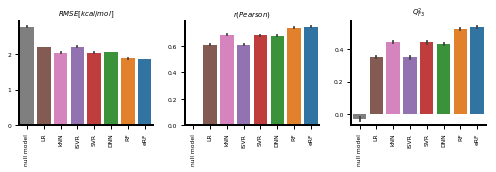

In [26]:
# Fix the colors
curr_palette = sns.color_palette()
rev_palette = curr_palette[7::-1] # Reversed so that the last entry gets the first color
(rev_palette[1], rev_palette[2]) = (rev_palette[2], rev_palette[1])

with plt.style.context(style_base):
    sns.catplot(data=test_derotb.query("metric in ['RMSE', 'r_pearson', 'Q2_F3']"
                                      ).replace({"RMSE":"$RMSE [kcal/mol]$", 
                                                 "r_pearson":"$r (Pearson)$",
                                                 "Q2_F3":"$Q_{F3}^{2}$"}), # 'r_spearman', 
                x="model", y="value", col="metric", kind="bar", palette=rev_palette,
                order=reversed(model_order), sharey=False, sharex=False,
               ).set_xticklabels(rotation=90).set_titles("{col_name}", fontweight="bold").set_xlabels('').set_ylabels('')
    plt.gcf().set_size_inches((7,2.5))
    plt.savefig(out/"basic_method_comparison_test.png")
    plt.gcf().set_size_inches((7,2.5))
    plt.savefig(out/"basic_method_comparison_test.svg")

# Plotting

## Feature importance

### Features (-rotb)

In [27]:
allowed_models = ["LR", "DNN", "eRF"]

#### On Test set

In [28]:
fi_test = all_fis_tidy.query(f"dataset == 'test' and run == 'de_rotb' and model in {allowed_models}")


fi_test.loc[:,"model"] = fi_test.model.cat.remove_unused_categories()

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [29]:
fi_test.model.cat.categories

Index(['LR', 'eRF', 'DNN'], dtype='object')

In [30]:
# sns.catplot(data=fi_test.loc[filter_equal("metric", "mean_squared_error")], 
#             y="feature", x="value", col="model", col_wrap=3, kind="bar", sharey=False, sharex=False,)

In [31]:
curr_palette = sns.color_palette()
fi_palette = [curr_palette[5],curr_palette[0],curr_palette[2]]

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


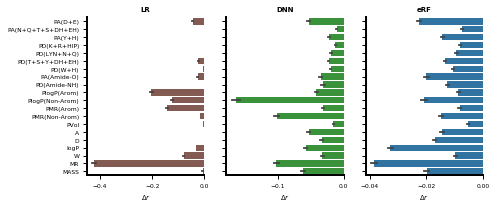

In [32]:
with plt.style.context(style_base):
    g = sns.catplot(data=fi_test.loc[filter_equal("metric", "r_pearson")], 
                y="feature", x="value", col="model", hue="model", 
                    col_wrap=3, col_order=allowed_models, order=feature_order,
                    palette=fi_palette,
                kind="bar", sharex=False, dodge=False).set_titles("{col_name}", fontweight="bold")
    g.set_xlabels("$\Delta r$").set_ylabels("")
    plt.tight_layout()
    plt.gcf().set_size_inches((7,3))
    plt.savefig(out/"fi_general_test.png")
    plt.gcf().set_size_inches((7,3))
    plt.savefig(out/"fi_general_test.svg")

### Trained on molecule features only

In [33]:
fi_test = all_fis_tidy.query(f"dataset == 'test' and run == 'molecule_only' and model in {allowed_models}")


fi_test.loc[:,"model"] = fi_test.model.cat.remove_unused_categories()

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


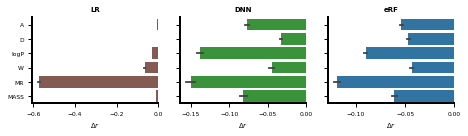

In [34]:
with plt.style.context(style_base):
    g = sns.catplot(data=fi_test.loc[filter_equal("metric", "r_pearson")], 
                y="feature", x="value", col="model", hue="model", 
                    col_wrap=3, col_order=allowed_models, 
                    order=ligand_order, palette=fi_palette,
                kind="bar", sharex=False, dodge=False).set_titles("{col_name}", fontweight="bold")
    g.set_xlabels("$\Delta r$").set_ylabels("")
    plt.tight_layout()
    plt.gcf().set_size_inches((6.6,2))
    plt.savefig(out/"fi_mol_only_test.png")
    plt.gcf().set_size_inches((6.6,2))
    plt.savefig(out/"fi_mol_only_test.svg")

### Trained on protein features only

In [35]:
fi_test = all_fis_tidy.query(f"dataset == 'test' and run == 'protein_only' and model in {allowed_models}")


fi_test.loc[:,"model"] = fi_test.model.cat.remove_unused_categories()

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


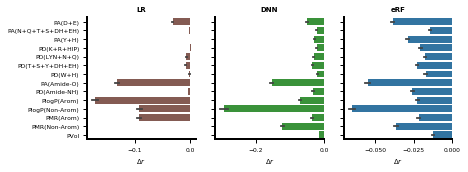

In [36]:
with plt.style.context(style_base):
    g = sns.catplot(data=fi_test.loc[filter_equal("metric", "r_pearson")], 
                y="feature", x="value", col="model", hue="model", 
                    col_wrap=3, col_order=allowed_models, 
                    order=protein_order, palette=fi_palette,
                kind="bar", sharex=False, dodge=False).set_titles("{col_name}", fontweight="bold")
    g.set_xlabels("$\Delta r$").set_ylabels("")
    plt.tight_layout()
    plt.gcf().set_size_inches((6.6,2.5))
    plt.savefig(out/"fi_prot_only_test.png")
    plt.gcf().set_size_inches((6.6,2.5))
    plt.savefig(out/"fi_prot_only_test.svg")

## Calculate for groups

### Perform grouping

In [37]:
# Filter runs to be just the common de_rotb run (Avoids issue with refiltered datasets)
preds_to_grp = all_preds.xs("de_rotb", level="run", drop_level=False)
grouped_predarrs = {}
grouped_externds = {}
for ds_grp_name, ds_grp in dataset_sets.items():
    all_series = [preds_to_grp.xs(ds, level="dataset") for ds in ds_grp]
    grouped_predarrs[ds_grp_name] = pd.concat(all_series, axis=1, ignore_index=True).aggregate(np.concatenate, axis=1)
    all_series = [external_datasets.xs(ds, level="dataset") for ds in ds_grp]
    grouped_externds[ds_grp_name] = pd.concat(all_series)
    

grouped_predarrs = pd.concat(grouped_predarrs, names=["dataset"]).rename("raw_predictions")
grouped_externds = pd.concat(grouped_externds, names=["dataset"])

### Calculate metric over grouped arrays

In [38]:
grouped_predarrs.index.names

FrozenList(['dataset', 'run', 'replicate', 'model', 'fold'])

In [39]:
grouped_metrics = pd.DataFrame(index=grouped_predarrs.index, columns=fi_met_cols, dtype="float")
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for ix_tple, pred_arr in grouped_predarrs.items():
        ds, run, repl, model, fold = ix_tple
        pred_arr = pred_arr.ravel()
        true_arr = grouped_externds.query(f"dataset == '{ds}'")["Expt_BE"].values.ravel()
        train_arr = pdbbind_ds["training"].loc[(run, repl, fold), "Expt_BE"].values.ravel()
        metric_arr = calc_metrics(true_arr, pred_arr)
        metric_arr += (q2_f3_score(true_arr, pred_arr, train_arr),)
        grouped_metrics.loc[ix_tple] = metric_arr
        
grouped_metrics["RMSE"] = np.sqrt(grouped_metrics["mean_squared_error"])

In [40]:
grouped_metrics_tidy = grouped_metrics.reset_index().melt(id_vars=metric_idx_cols, value_vars=metric_met_cols[:-1], 
                                           value_name="value", var_name="metric")

## All datasets

In [41]:
grouped_metrics_filtered = grouped_metrics_tidy.query("model == 'eRF' "
                                                  "and metric in ['RMSE', 'r_pearson', 'Q2_F3']")

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


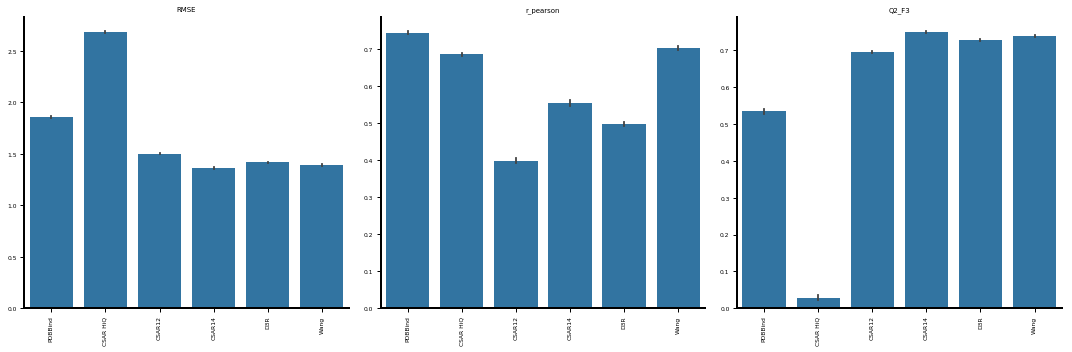

In [42]:
interm = all_metrics_tidy.query("run == 'de_rotb'"
                               "and model == 'eRF' "
                            "and metric in ['RMSE', 'r_pearson', 'Q2_F3']"
                              "and dataset == 'test'")
interm.dataset = "PDBBind"
# print(interm.groupby("model").count())

interm = pd.concat([interm, grouped_metrics_filtered.query("run == 'de_rotb'")])
# print(interm.groupby("model").count())
with plt.style.context(style_base):

    (sns.catplot(data=interm, x="dataset", y="value", col="metric", hue="model", 
                sharex=False, kind="bar", sharey=False, legend=False)
     .set_titles("{col_name}")
     .set_xticklabels(rotation=90)
     .set_xlabels('')
     .set_ylabels(''))
    plt.tight_layout()
    plt.savefig(out/"erf_external_sets.png")
    plt.savefig(out/"erf_external_sets.svg")

Check the results for the mean value predicting model

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


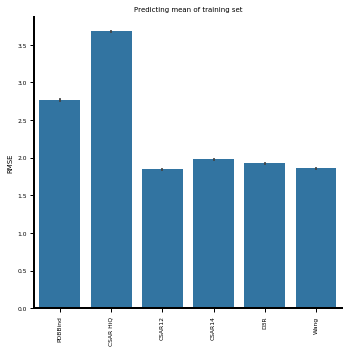

In [43]:
interm = all_metrics_tidy.query("run == 'de_rotb' and dataset == 'test'")
interm.dataset = "PDBBind"

interm = pd.concat([interm,  grouped_metrics_tidy.query("run == 'de_rotb'")])
interm= interm.query("model == 'null model' "
                    "and metric in ['RMSE']")

with plt.style.context(style_base):

    (sns.catplot(data=interm, x="dataset", y="value", col="metric", hue="model",
                sharex=False, kind="bar", sharey=False, legend=False)
     .set_titles("Predicting mean of training set")
     .set_xticklabels(rotation=90)
     .set_xlabels('')
     .set_ylabels('RMSE'))
    plt.tight_layout()
    plt.savefig(out/"meanpred_external_sets.png")
    plt.savefig(out/"meanpred_external_sets.svg")

#### Big overview

In [44]:
grouped_metrics_tidy.query("run == 'de_rotb' and model == 'eRF'"
                          ).groupby(["dataset","metric"]).mean()["value"].unstack(level="metric")

metric,Q2_F3,RMSE,mean_squared_error,median_absolute_error,r2_score,r_pearson,r_spearman
dataset,,,,,,,
CSAR HiQ,0.028779,2.683996,7.204657,1.514019,0.408601,0.685123,0.685014
CSAR12,0.696407,1.500670,2.252381,0.970286,0.029628,0.398096,0.320693
CSAR14,0.749542,1.362736,1.857920,0.948238,0.243403,0.553546,0.364789
D3R,0.728179,1.419879,2.016512,0.955753,0.162644,0.497484,0.360041
Wang,0.739969,1.388561,1.928978,0.829614,0.412875,0.701993,0.650603


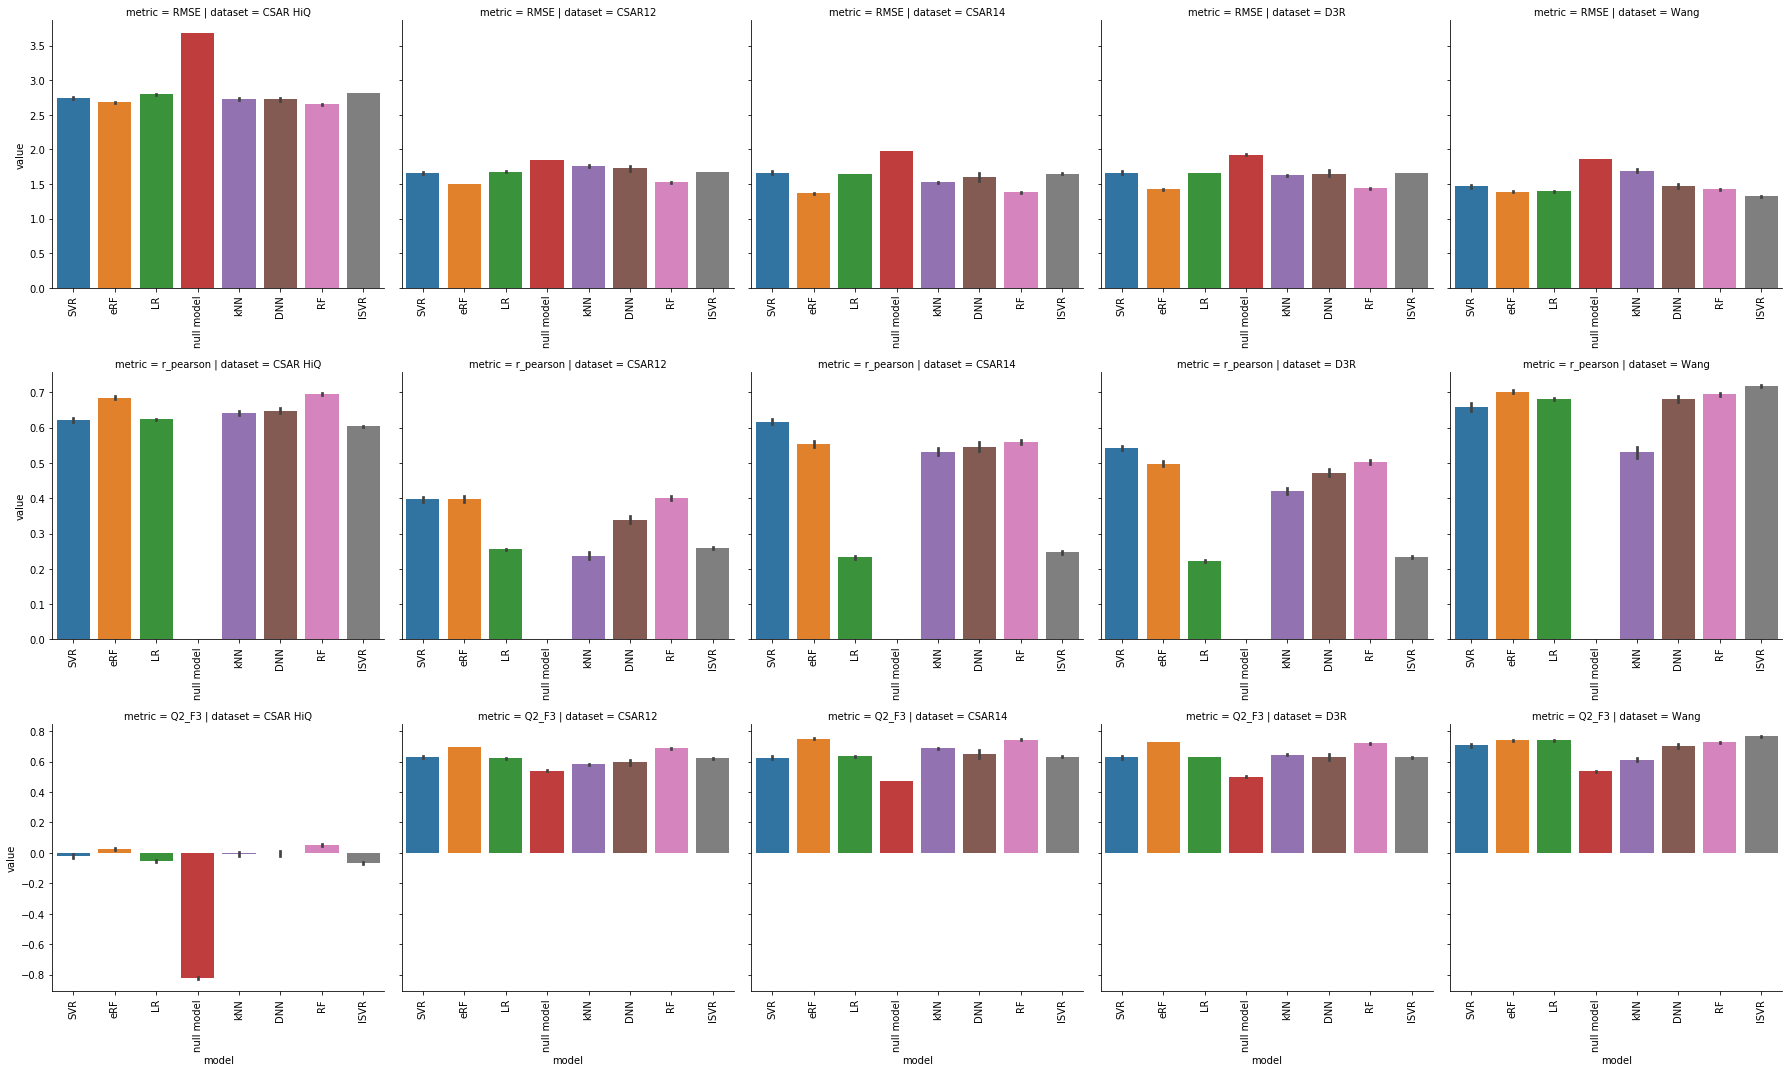

In [45]:
grouped_metrics_filtered = grouped_metrics_tidy.query("metric in ['RMSE', 'r_pearson', 'Q2_F3']"
                            "and run == 'de_rotb'"
                                                 )

sns.catplot(data=grouped_metrics_filtered, x="model", y="value", 
            col="dataset", row="metric", kind="bar", sharey="row", sharex=False).set_xticklabels(rotation=90)
plt.tight_layout()

## Scatter plots

As eRF performed best we will use the 0 replicate/shuffle and the 0 fold for plotting scatter distributions

Train/Valid/Test

In [46]:
tvt_pred = all_preds.to_frame()\
        .query("model == 'eRF'"
                "and run == 'de_rotb'"
                "and replicate == 0"
                "and fold == 0"
                "and dataset in ['test', 'training', 'validation']"
               )["raw_predictions"]

All grouped datasets

In [47]:
dsgrp_pred = grouped_predarrs.to_frame()\
        .query("model == 'eRF'"
                "and run == 'de_rotb'"
                "and replicate == 0"
                "and fold == 0"
              )["raw_predictions"].reorder_levels(tvt_pred.index.names)

In [48]:
pred_to_plot = pd.concat([tvt_pred, dsgrp_pred])

In [49]:
pred_to_plot.index.names

FrozenList(['run', 'replicate', 'dataset', 'model', 'fold'])

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


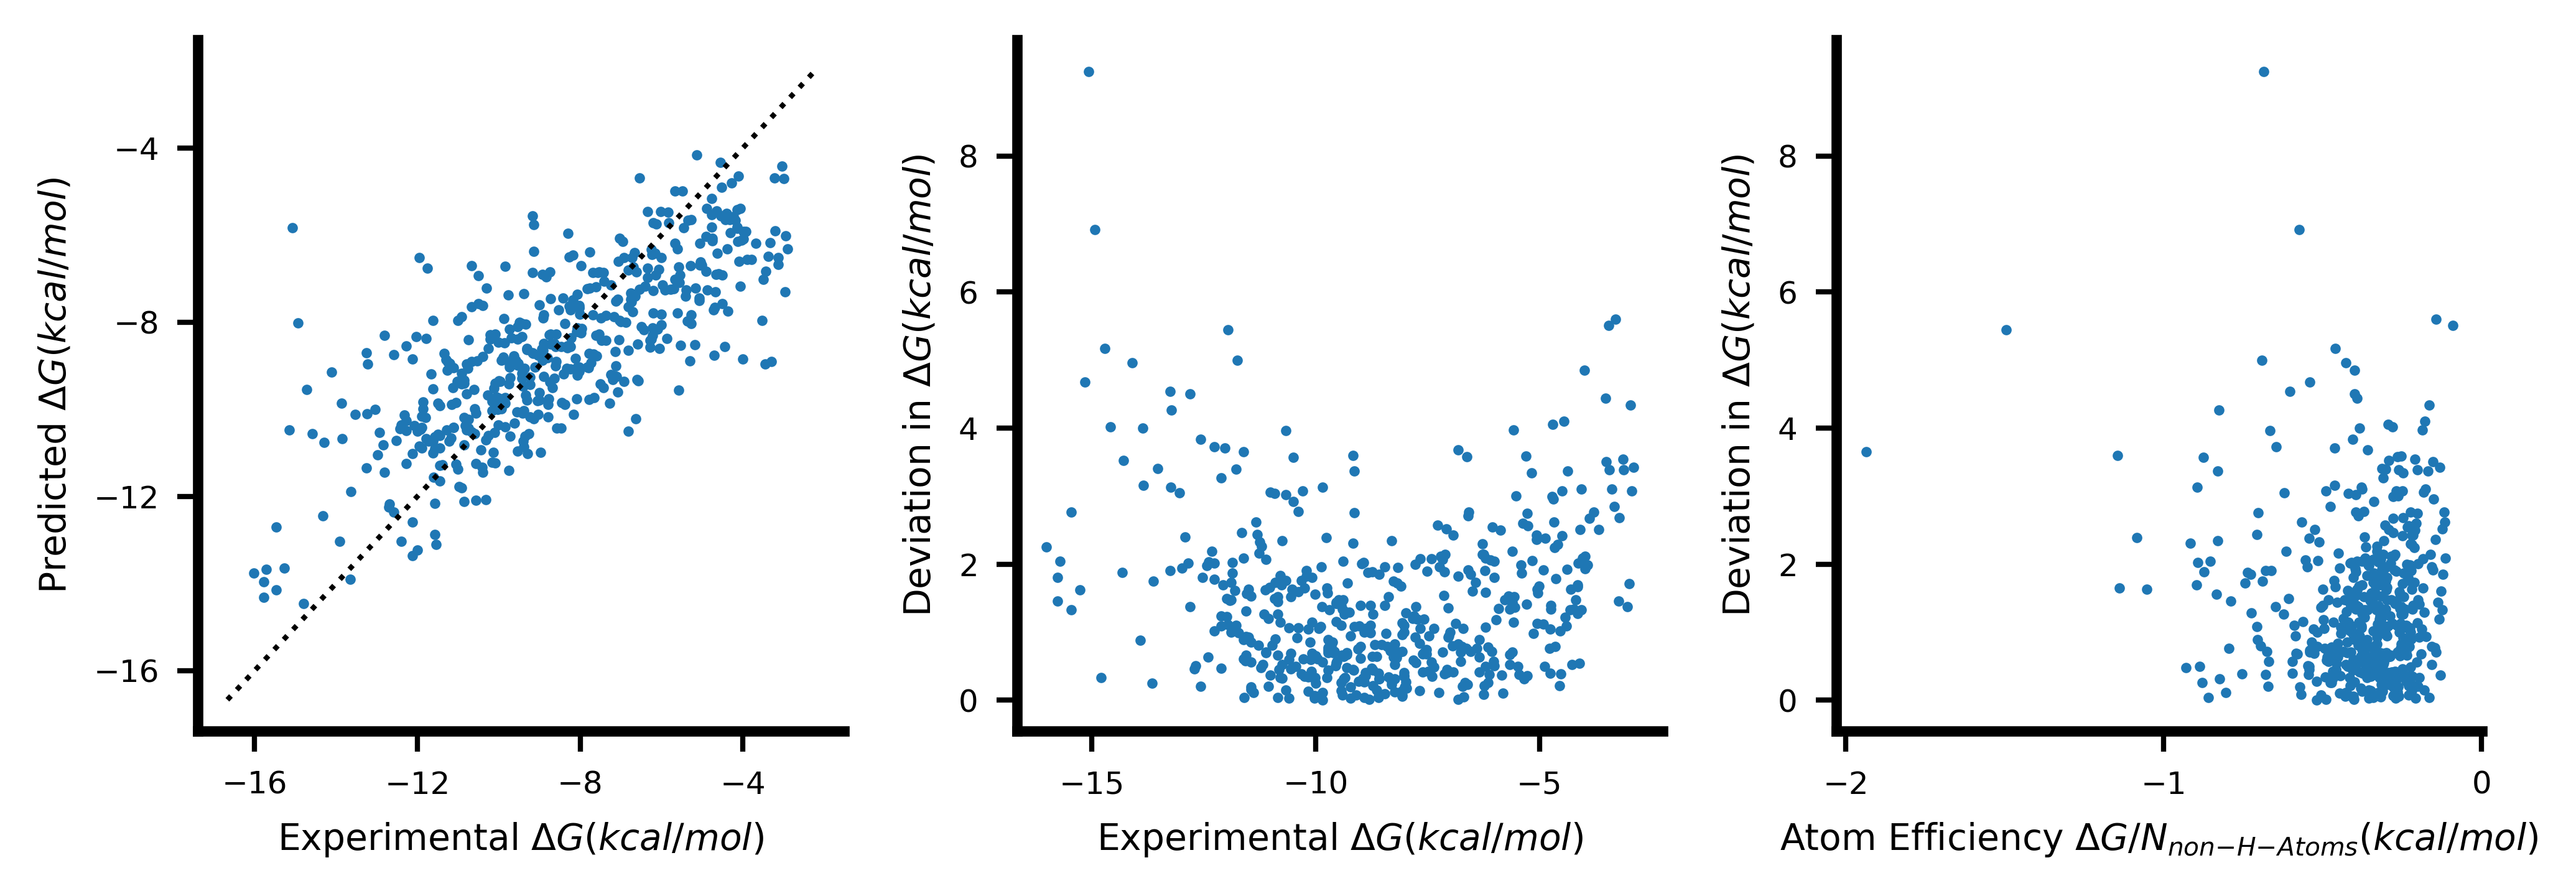

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


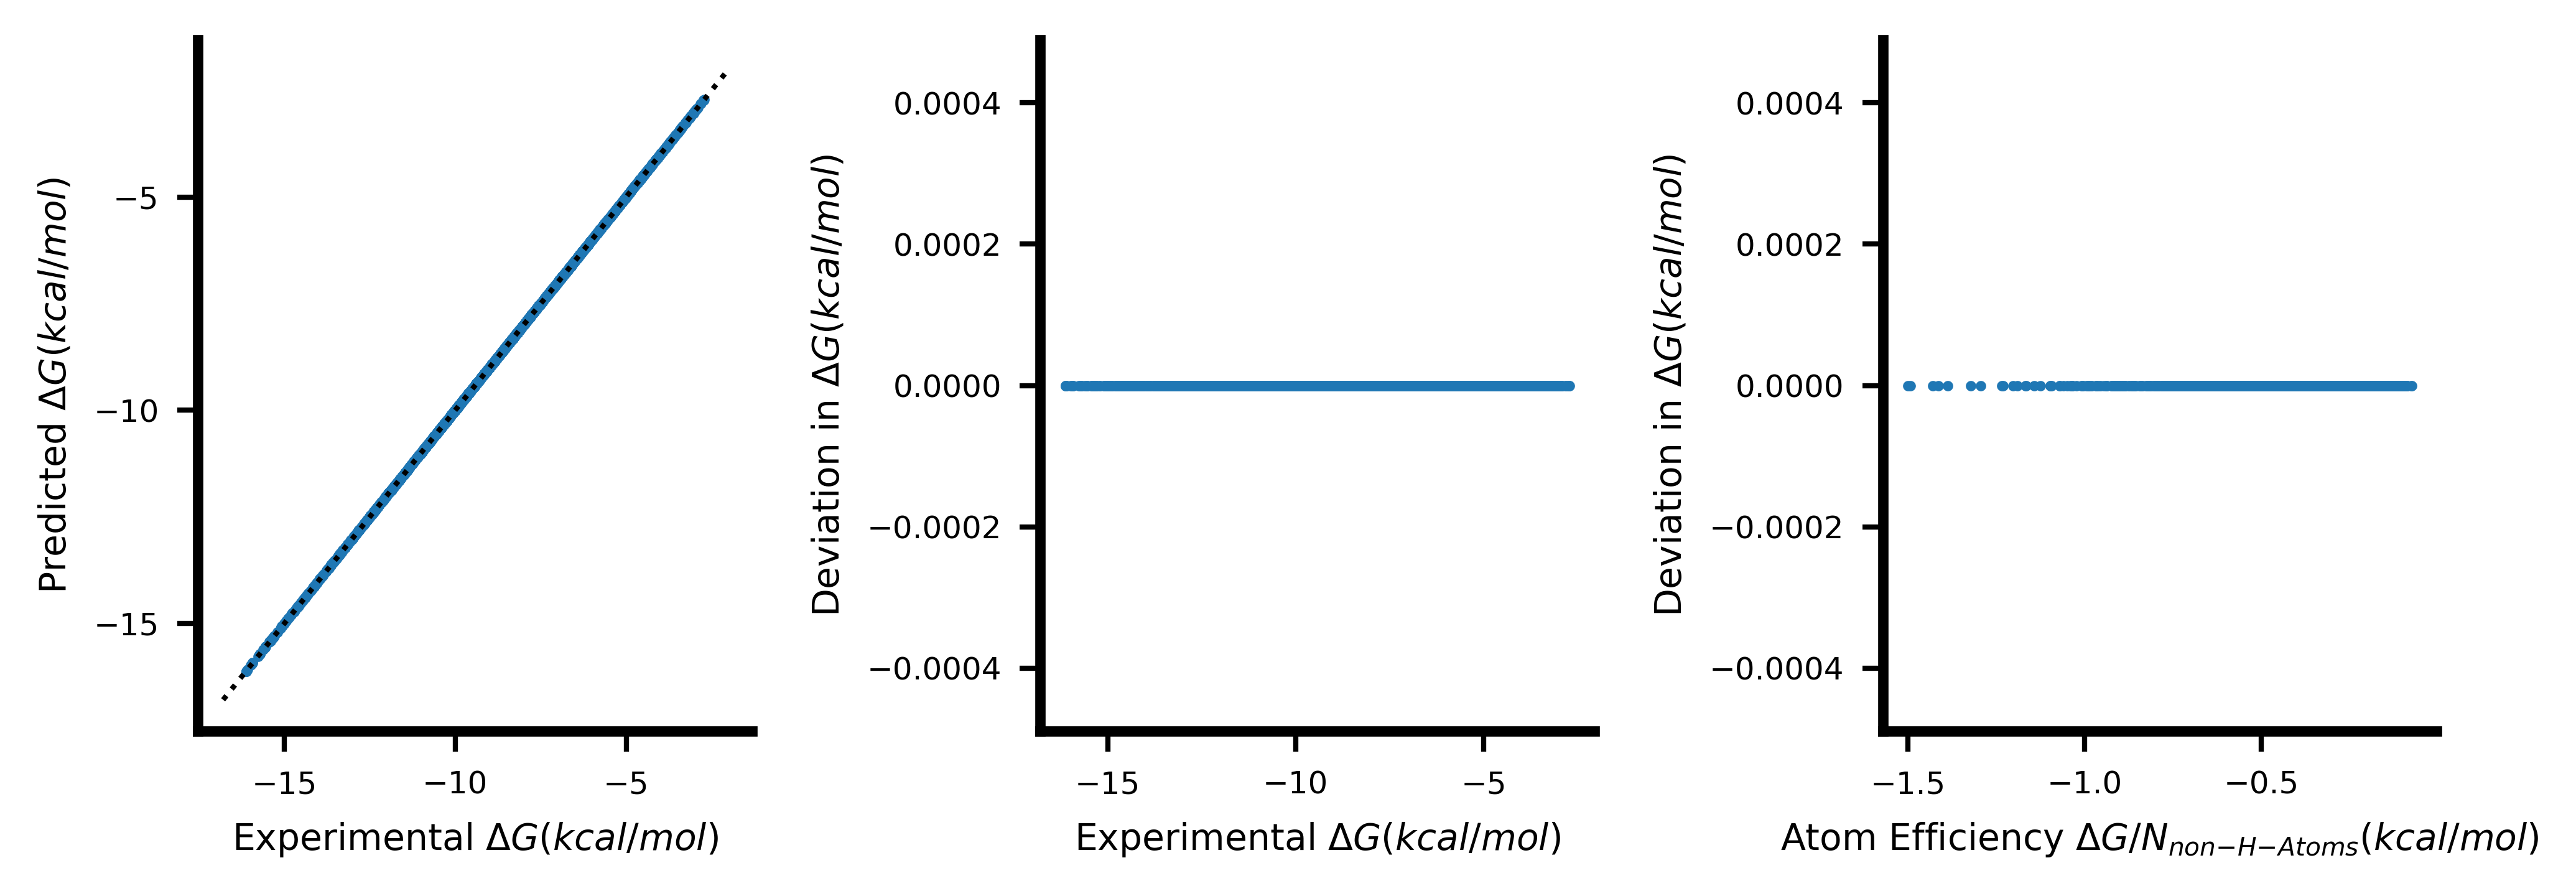

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


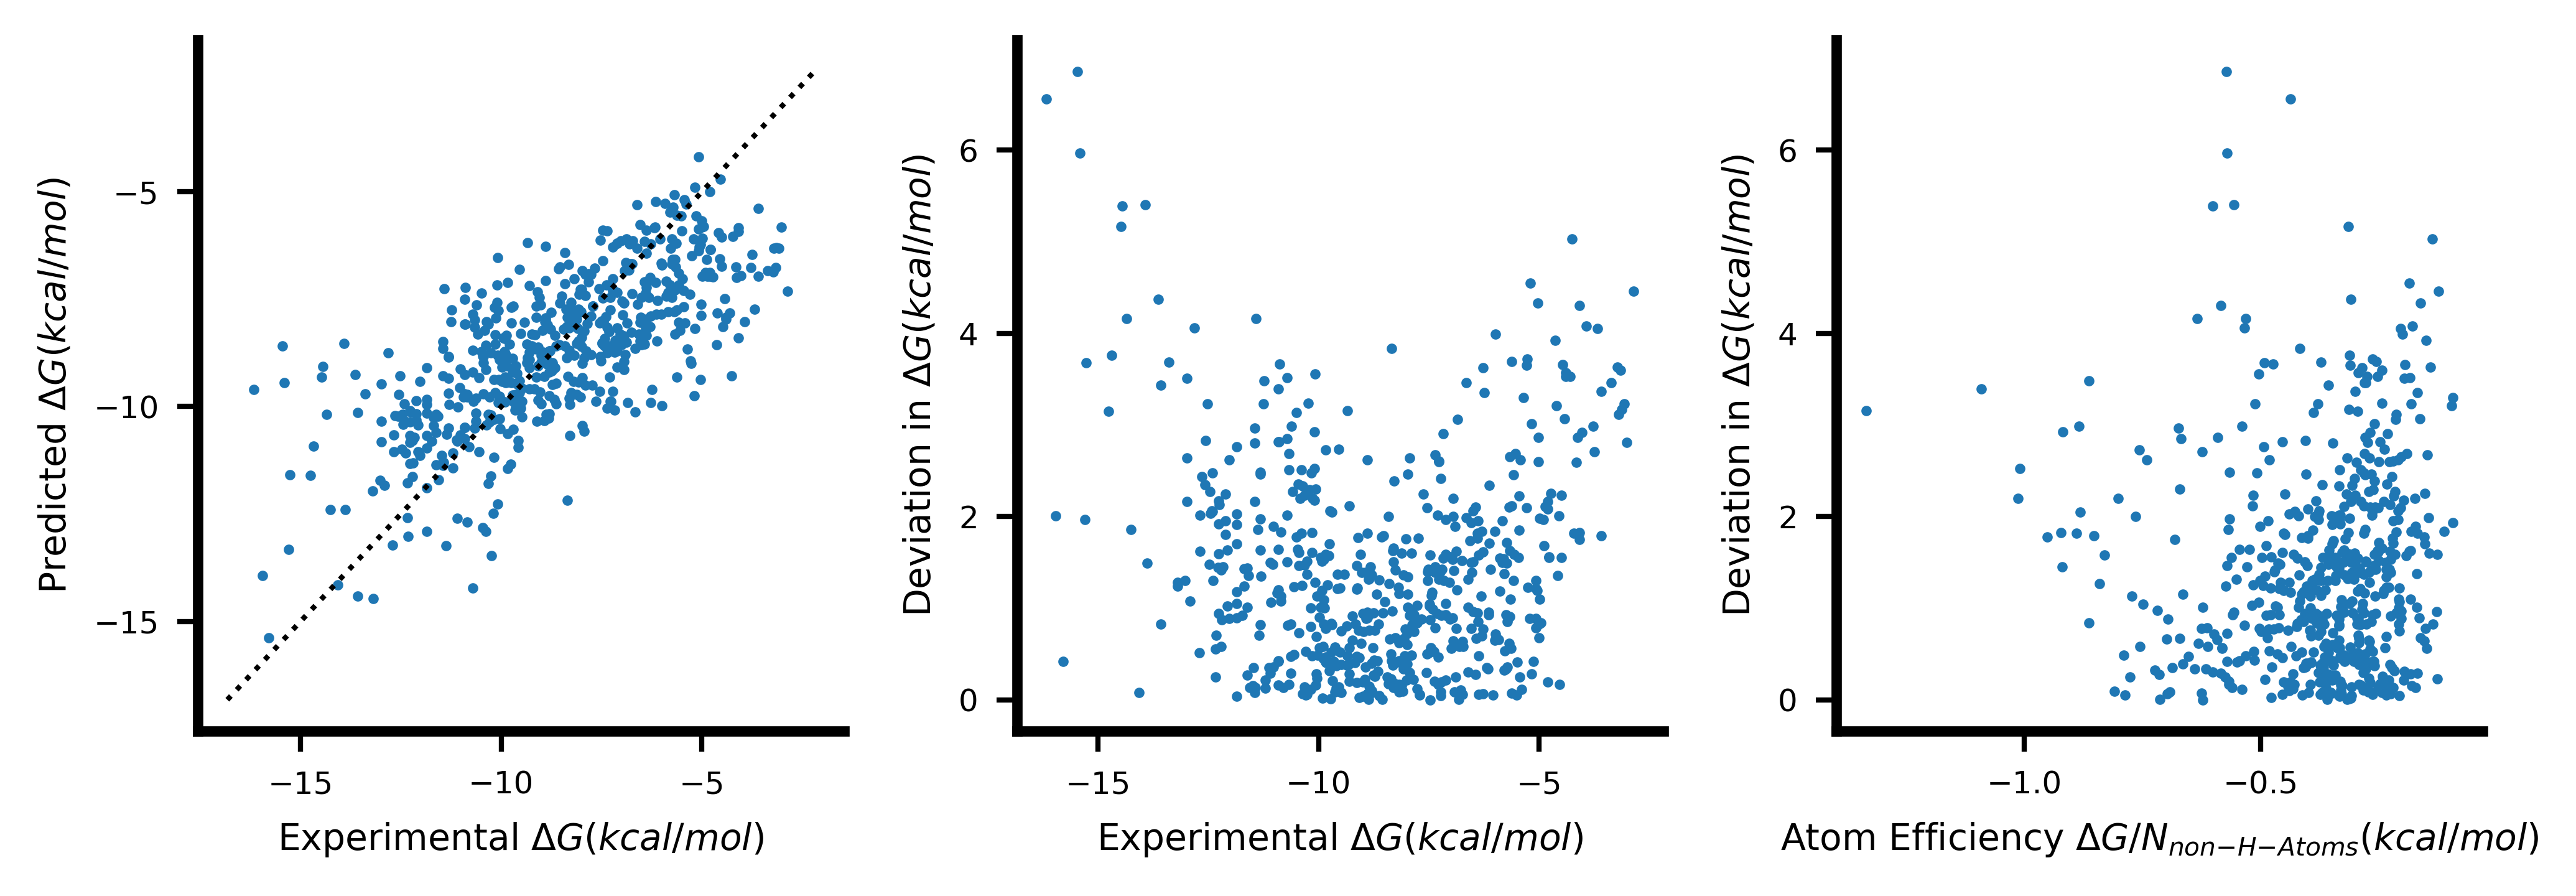

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


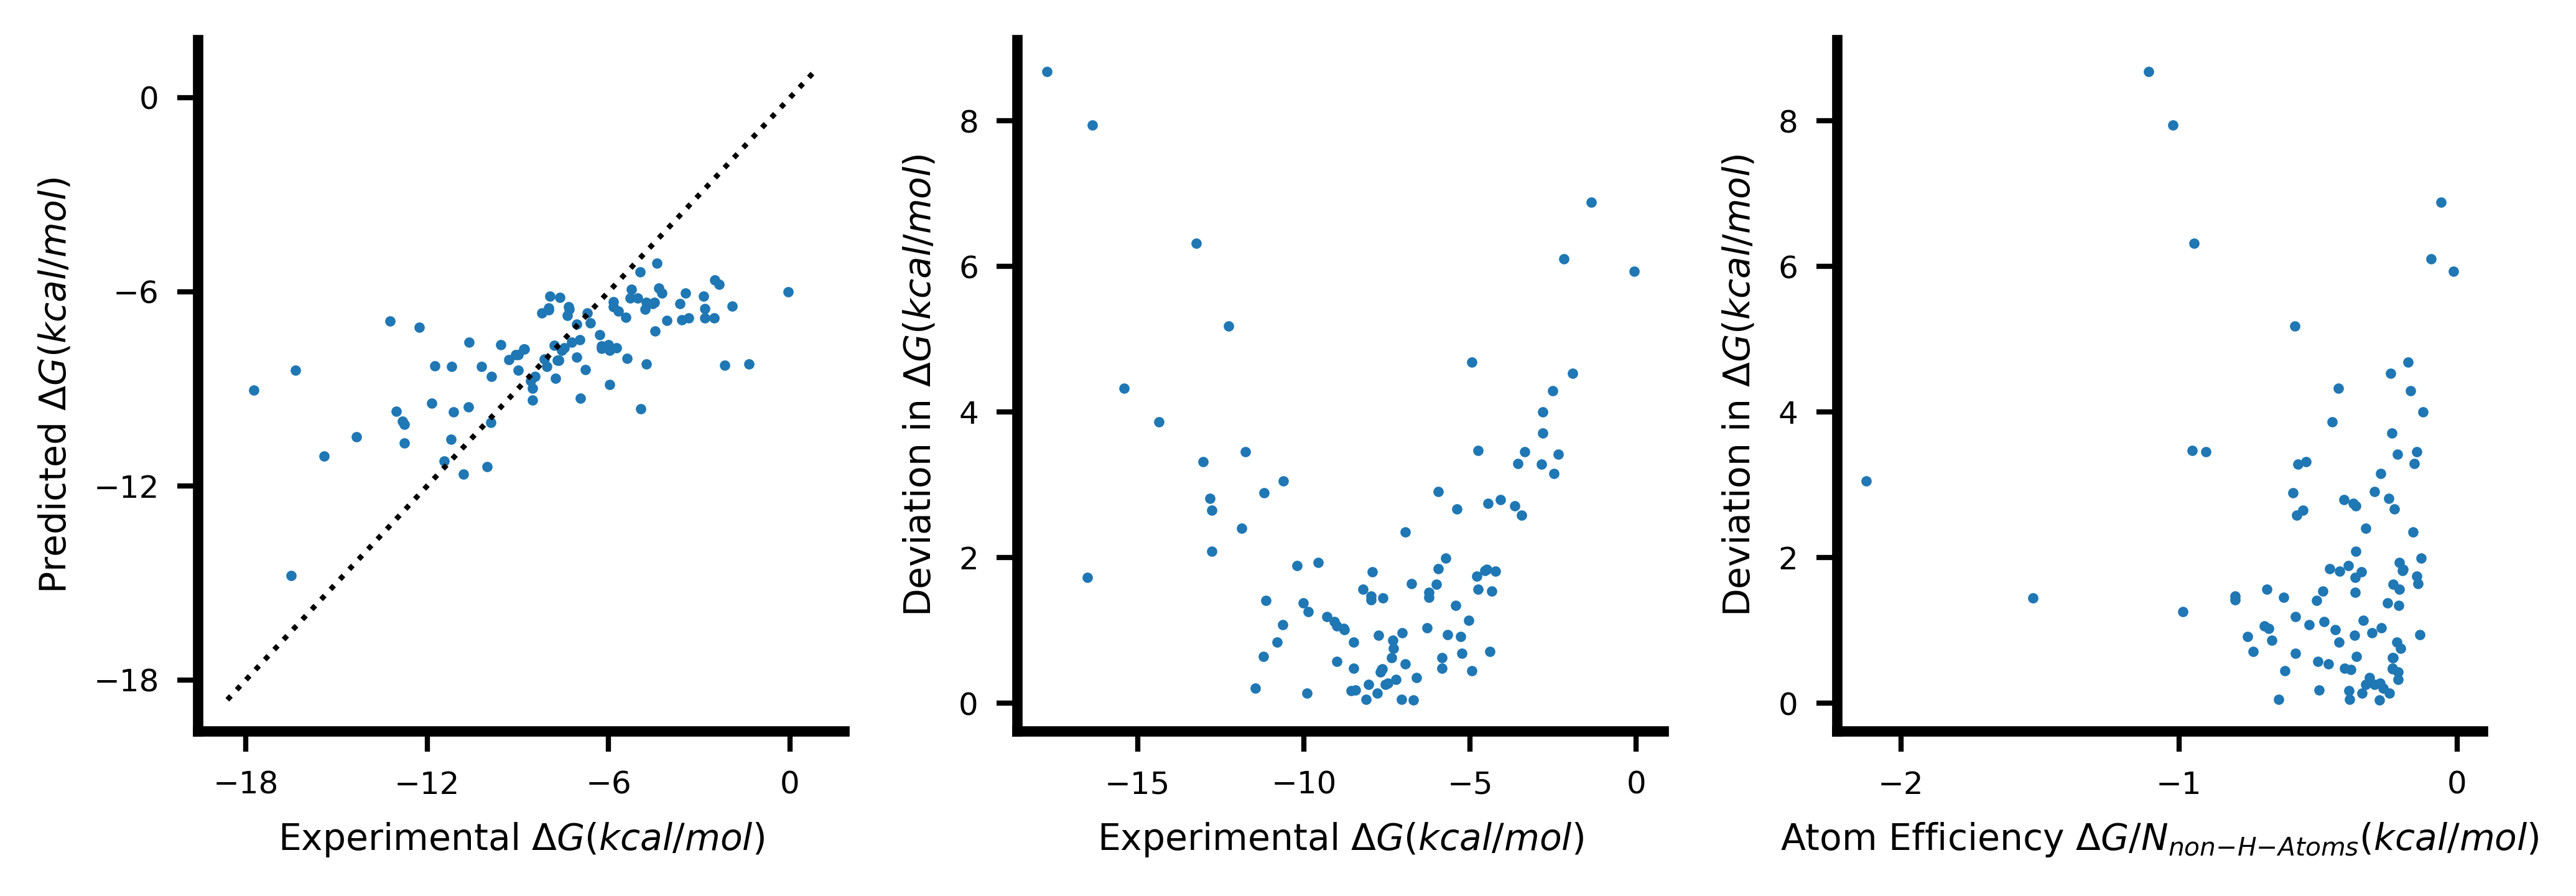

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


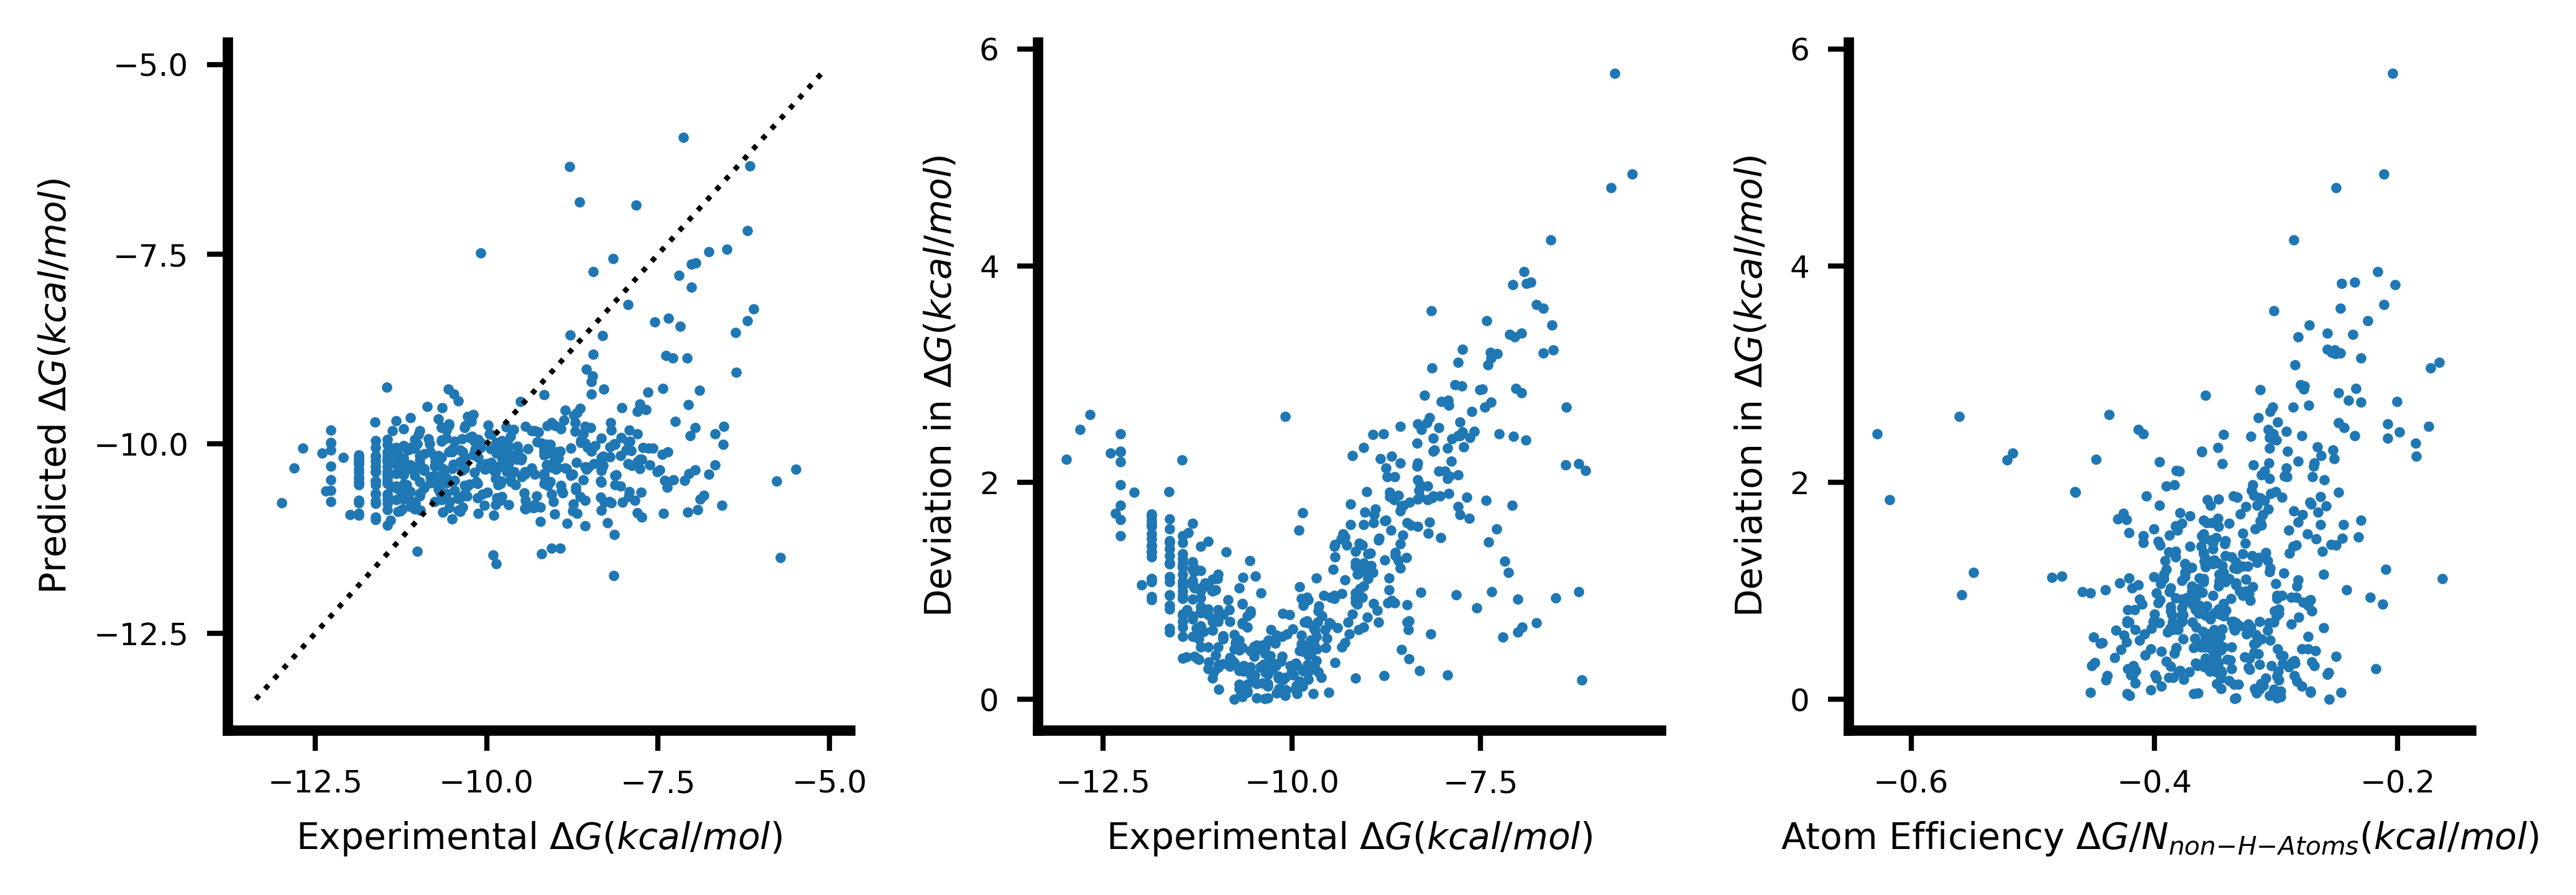

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


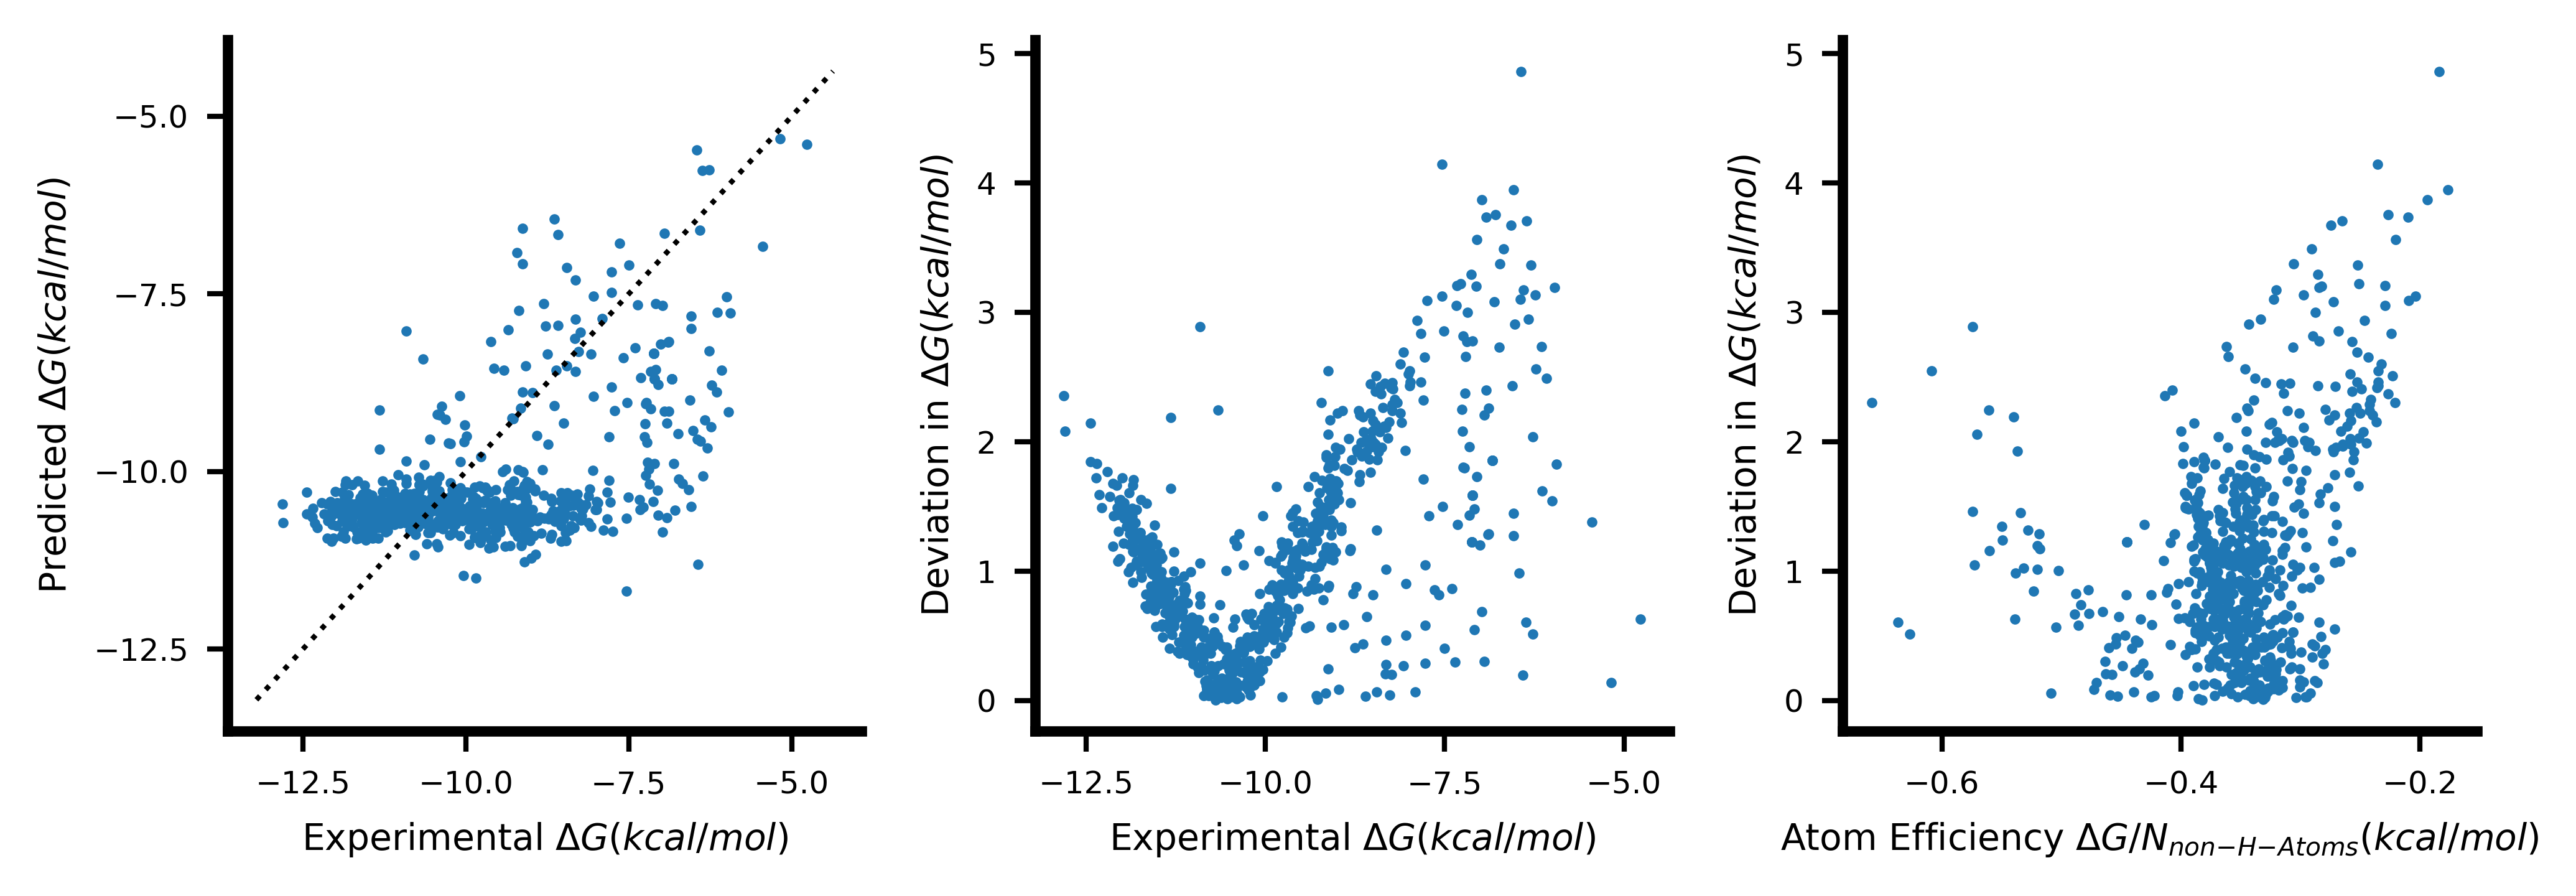

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


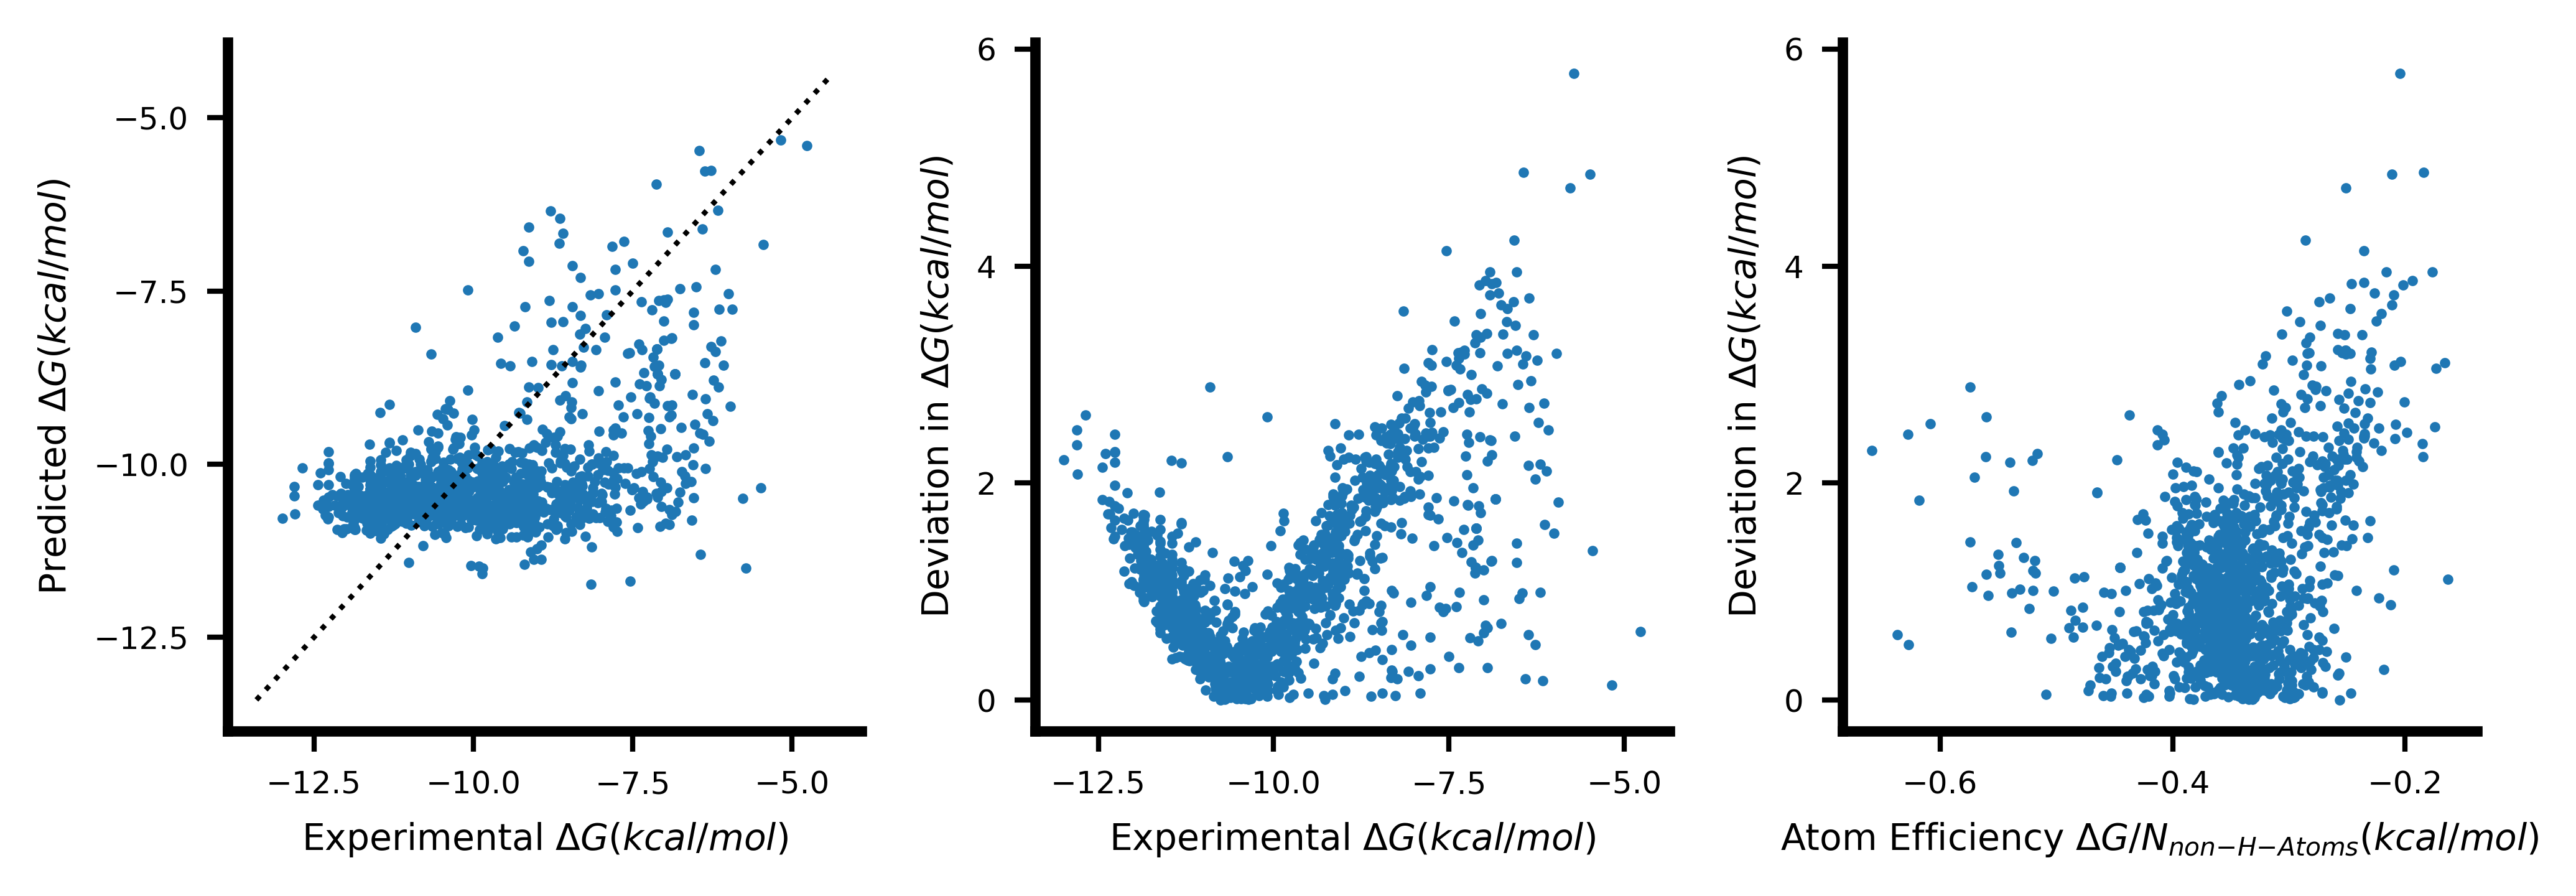

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


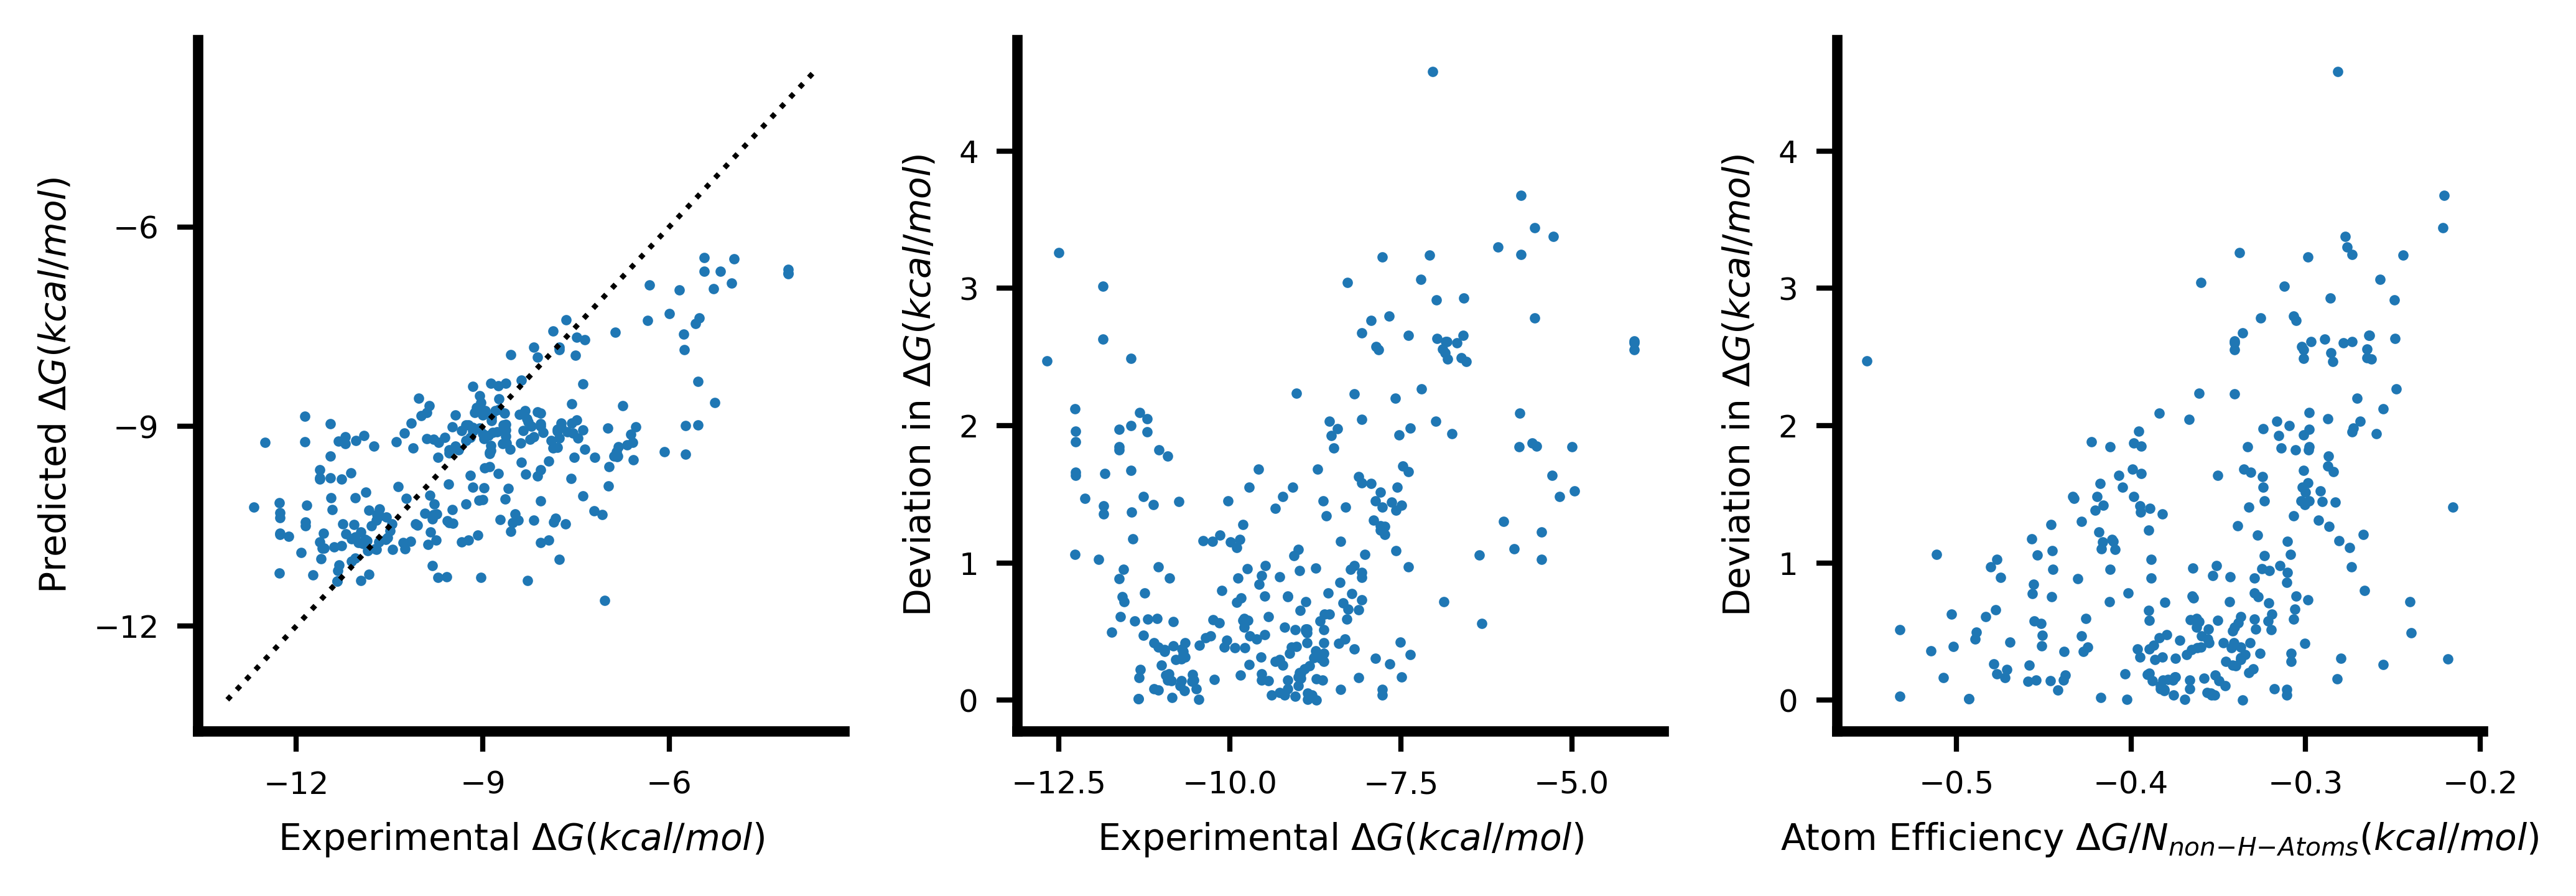

In [50]:
plots = []
for idx_tple, pred_arr in pred_to_plot.items():
    pred_arr = pred_arr.ravel()
    run, repl, ds, model, fold = idx_tple
    if ds in dataset_sets:
        true_arr = grouped_externds.query(f"dataset == '{ds}'")["Expt_BE"].values.ravel()
        ae_arr = grouped_externds.query(f"dataset == '{ds}'")["Atom_Efficiency"].values.ravel()
    elif ds == "test":
        true_arr = pdbbind_ds["test"].loc[(run, repl), "Expt_BE"].values.ravel()
        ae_arr = pdbbind_ds["test"].loc[(run, repl), "Atom_Efficiency"].values.ravel()
    elif ds in ("training", "validation"):
        true_arr = pdbbind_ds[ds].loc[(run, repl, fold), "Expt_BE"].values.ravel()
        ae_arr = pdbbind_ds[ds].loc[(run, repl, fold), "Atom_Efficiency"].values.ravel()
    else:
        raise ValueError(f"ds {ds} not found")
#     print(true_arr.shape, ae_arr.shape)
    err_arr = np.abs(pred_arr - true_arr)
    with plt.style.context(style_base):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7,2.5), dpi=600)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Comparison scatterplot
        ax1.scatter(true_arr, pred_arr, s=1)
        ax1.plot(ax1.get_xlim(), ax1.get_xlim(), linestyle=":", color="black")
        ax1.xaxis.set_major_locator(ticker.MaxNLocator(4))
        ax1.yaxis.set_major_locator(ticker.MaxNLocator(4))
        ax1.set_title("")

        ax1.set_xlabel("Experimental $\Delta G (kcal/mol)$")
        ax1.set_ylabel("Predicted $\Delta G (kcal/mol)$")
        # Error dependence delta G
        ax2.scatter(true_arr, err_arr, s=1)
        ax2.set_xlabel("Experimental $\Delta G (kcal/mol)$")
        ax2.set_ylabel("Deviation in $\Delta G (kcal/mol)$")
        # Error dependence delta G
        ax3.scatter(ae_arr, err_arr, s=1)
        ax3.set_xlabel(r"Atom Efficiency ${\Delta G}/{N_{non{-}H{-}Atoms}} (kcal/mol)$")
        ax3.set_ylabel("Deviation in $\Delta G (kcal/mol)$")
        #fig.suptitle(f"Evaluation of {model} on {ds}")
        fig.set_size_inches((7, 2.5))
        fig.savefig(out / f"individual_{ds}_{model}_{run}_{repl}_{fold}.png")
        fig.savefig(out / f"individual_{ds}_{model}_{run}_{repl}_{fold}.svg")
        plots.append(fig)


### Protein level plots for Wang, CSAR12, CSAR14

#### Which data

In [51]:
preds_indiv = preds_to_grp.loc[('de_rotb', 0, slice(None), 'eRF', 0)].sort_index()
preds_indiv

dataset
BACE             [-9.138465000000002, -9.010924999999997, -9.86...
CDK2             [-11.619620000000003, -10.401244999999994, -10...
CDK2 Kinase      [-8.221314999999999, -6.8530200000000026, -8.5...
CDK2-Cyclin A    [-8.344199999999997, -6.342864999999996, -8.56...
CHK1 Kinase      [-10.078200000000004, -9.989405000000005, -9.5...
CSAR HiQ 1       [-5.114944999999994, -6.372560000000008, -6.66...
CSAR HiQ 2       [-11.241705000000001, -6.804600000000001, -6.8...
ERK2             [-10.097124999999995, -10.461615000000004, -9....
HSP90            [-9.163495000000006, -9.145745000000005, -9.25...
LpxC             [-10.337199999999998, -11.49645, -9.621385, -9...
Mcl-1            [-9.080535000000008, -9.158415000000003, -9.37...
Mcl-1 all        [-6.642299999999999, -6.927930000000004, -7.40...
PTP1B            [-6.48286, -7.586549999999994, -7.659034999999...
SYK              [-10.633585000000012, -10.633585000000012, -10...
TYK2             [-10.415115000000014, -11.09008000000

In [52]:
preds_folds = preds_to_grp.loc[('de_rotb', slice(None), slice(None), 'eRF', slice(None))].sort_index()
preds_folds

replicate  dataset        fold
0          BACE           0       [-9.138465000000002, -9.010924999999997, -9.86...
                          1       [-9.120900000000002, -8.405634999999997, -9.25...
                          2       [-9.006430000000002, -8.759059999999996, -9.85...
                          3       [-9.206434999999995, -8.890315000000001, -10.0...
                          4       [-9.055539999999997, -8.997979999999995, -9.90...
                          5       [-9.029025000000003, -8.885709999999994, -9.76...
           CDK2           0       [-11.619620000000003, -10.401244999999994, -10...
                          1       [-11.567154999999996, -10.256835000000002, -10...
                          2       [-11.855355000000005, -10.312205000000006, -10...
                          3       [-11.613045, -10.294759999999997, -10.58138500...
                          4       [-11.353304999999999, -10.241180000000002, -10...
                          5       [-10.910794

#### Prep plots

In [53]:
pred_datasets = external_datasets.sort_index(level='dataset', sort_remaining=False)
pred_datasets

Expt_BE  Atom_Efficiency
dataset PDBID                          
BACE    4o       -8.91        -0.330000
        13e      -9.49        -0.379600
        17b      -9.55        -0.382000
        13k      -9.23        -0.341852
        4m       -8.68        -0.321481
        4b       -9.16        -0.327143
        4p       -9.61        -0.355926
        17f      -8.96        -0.358400
        4l       -8.87        -0.341154
        13g      -8.63        -0.319630
        17e      -9.54        -0.381600
        13b      -8.65        -0.376087
        4a       -7.47        -0.287308
        4k       -7.39        -0.284231
        13a      -8.38        -0.380909
        17d      -8.96        -0.389565
        13i      -8.80        -0.352000
        17c      -9.39        -0.375600
        24      -11.27        -0.433462
        13m      -8.29        -0.307037
        4i       -7.80        -0.300000
        4j       -8.56        -0.329231
        13f      -8.63        -0.331923
        13n      -8.07        -0.298889
        13h      -9.16        -0.366400
        13d      -9.99        -0.416250
        4d       -8.64        -0.297931
        17i      -9.00        -0.375000
        17a     -10.26        -0.410400
        17g      -9.27        -0.386250
...                ...              ...
p38     2aa      -9.27        -0.343333
        2o      -10.49        -0.317879
        2v       -8.97        -0.390000
        2t      -11.85        -0.395000
        3fly    -11.42        -0.456800
        3fmk    -11.83        -0.394333
        2g      -10.66        -0.394815
        2p      -11.20        -0.329412
        2i      -10.05        -0.372222
        2l      -12.26        -0.422759
        2j      -10.08        -0.360000
        2ff     -11.44        -0.394483
        2s      -11.11        -0.347187
        2z      -10.36        -0.383704
        2ee     -12.26        -0.395484
        2u      -12.26        -0.331351
        3fln    -10.88        -0.388571
        2e      -10.70        -0.396296
        2f       -8.48        -0.314074
        3flw    -10.68        -0.368276
        2k      -10.55        -0.390741
        2x      -10.23        -0.378889
        2q      -12.26        -0.350286
        2gg     -10.66        -0.355333
        2y       -9.78        -0.362222
        2r      -10.79        -0.337187
        2bb      -9.06        -0.323571
        2m      -10.96        -0.365333
        3fmh    -10.83        -0.361000
        2h       -9.48        -0.351111

[1707 rows x 2 columns]

In [54]:
preds_indiv = preds_indiv.loc[pred_datasets.index.levels[0]]
preds_folds = preds_folds.swaplevel(0,1)

In [55]:
preds_indiv_stacked = preds_indiv.transform(pd.Series).stack()
preds_indiv_stacked.name = 'Pred_BE'

In [56]:
preds_folds_stacked = preds_folds.transform(pd.Series).rename_axis('points', axis=1).stack()
preds_folds_stacked.name = 'Pred_BE'

In [57]:
preds_mean_fold = preds_folds_stacked.groupby(['dataset', 'points']).mean()
preds_mean_fold = preds_mean_fold.loc[pred_datasets.index.levels[0], :]

In [58]:
pred_datasets['pred_BE'] = preds_indiv_stacked.values

In [59]:
pred_datasets['pred_BE_avg'] = preds_mean_fold.values

In [60]:
def plot_corr(true_arr, pred_arr, **kwargs):

    ax1 = plt.gca()
    ax1.scatter(true_arr, pred_arr, s=1)
    ax1.plot(ax1.get_xlim(), ax1.get_xlim(), linestyle=":", color="black")
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(4))
    ax1.yaxis.set_major_locator(ticker.MaxNLocator(4))
    ax1.set_title("")

In [61]:
def plot_indiv_proteins(ds, rows=1):
    with plt.style.context(style_base):
        g = sns.FacetGrid(# 
                col='dataset', col_wrap=3, 
                data=pred_datasets.reset_index(),
                col_order=dataset_sets[ds],
                sharex=False, sharey=False)
        g.map(plot_corr, 'Expt_BE', 'pred_BE_avg') # currently in average mode!
        g.set_titles("{col_name}").set_xlabels("Experimental $\Delta G$").set_ylabels("Predicted $\Delta G$")
        fig = plt.gcf()
        fig.set_size_inches((7, 2.5*rows))
        fig.savefig(out / f"scatter_protein_{ds}.svg")

#### CSAR 12

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


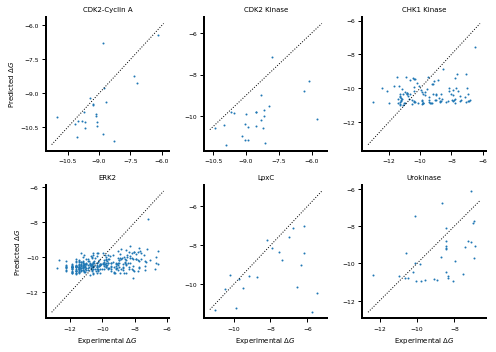

In [62]:
plot_indiv_proteins('CSAR12', rows=2)

#### CSAR 14

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


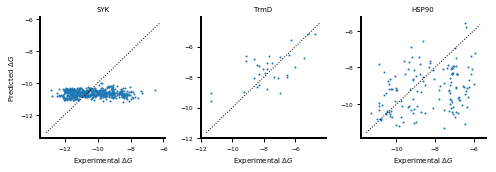

In [63]:
plot_indiv_proteins('CSAR14', rows=1)

#### Wang

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


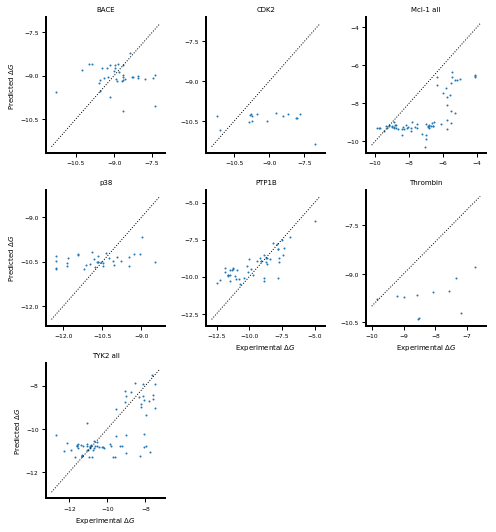

In [64]:
plot_indiv_proteins('Wang', rows=3)

### Ablation study

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


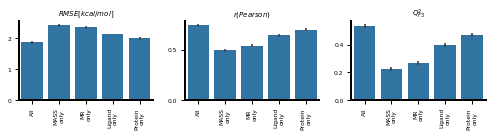

In [65]:
metrics_filtered = all_metrics_tidy.query("metric in ['RMSE', 'r_pearson', 'Q2_F3']"
                                         "and run in ['de_rotb', 'mw_only', 'mr_only', 'molecule_only', 'protein_only']"
                                         "and dataset == 'test'"
                                         "and model == 'eRF'")
metrics_filtered.model.cat.remove_unused_categories(inplace=True)
with plt.style.context(style_base):
    (sns.catplot(data=metrics_filtered.replace({"RMSE":"$RMSE [kcal/mol]$", 
                                                 "r_pearson":"$r (Pearson)$",
                                                 "Q2_F3":"$Q_{F3}^{2}$"})
                 , x="run", y="value", 
                col="metric", kind="bar", order=['de_rotb' , 'mw_only', 'mr_only', 'molecule_only', 'protein_only'],
                 hue="model",
                sharex=False, sharey=False, legend=False)
     .set_xticklabels(["All", "MASS\nonly", "MR\nonly", "Ligand\nonly", "Protein\nonly"], rotation=90)
     .set_xlabels('').set_ylabels('')
     .set_titles("{col_name}"))
    plt.tight_layout()
    plt.gcf().set_size_inches(7,2)
    plt.savefig(out/"ablation_test.png")
    plt.savefig(out/"ablation_test.svg")

### Benchmarking timing stuff

In [66]:
comp_perf = all_ds_sizes.to_frame()

comp_perf.columns = ["size"]

comp_perf = pd.merge(comp_perf, all_metrics, on=metric_idx_cols, sort=False, how="left")[["model", "size", "time", 'run']]

comp_perf = comp_perf[~comp_perf["time"].isna()]
comp_perf["total_time"] = comp_perf["time"] * comp_perf["size"]

comp_perf.query('model == "eRF" and run == "de_rotb"').mean()

size          1308.333333
time             0.000056
total_time       0.058271
dtype: float64

## Make useful tables 

In [67]:
ds_sizes = all_ds_sizes.xs('de_rotb').groupby('dataset').mean().to_frame()
ds_sizes = ds_sizes.rename(columns={'raw_predictions': 'N'})

ds_grp_sizes = pd.Series({grname: ds_sizes.loc[nlist,:].values.sum() 
                          for grname, nlist in dataset_sets.items()})
ds_grp_sizes = ds_grp_sizes.to_frame().rename(columns={0:'N'})
ds_grp_sizes.index.name = 'dataset'

### Dataset size

In [68]:
all_ds_sizes.xs('validation', level='dataset').xs('de_rotb', level='run').unique()

array([572])

In [69]:
all_ds_sizes.groupby('dataset').first()

dataset
BACE               36
CDK2               16
CDK2 Kinase        25
CDK2-Cyclin A      23
CHK1 Kinase       110
CSAR HiQ 1         54
CSAR HiQ 2         47
ERK2              298
HSP90             146
LpxC               20
Mcl-1              36
Mcl-1 all          67
PTP1B              48
SYK               583
TYK2               16
TYK2 all           71
Thrombin           11
TrmD               31
Urokinase          35
p38                34
test              493
training         2860
validation        572
Name: raw_predictions, dtype: int64

## Tables Benchmark Comparison

##### Load external benchmarks

In [121]:
benchmark_rmse = pd.read_csv("rmse_external_benchmarks.csv", index_col="System")

In [122]:
benchmark_pearson = pd.read_csv("r_pearson_external_benchmarks.csv", index_col="System")

##### Wrangling together table 2

In [123]:
wrangled_bench = pd.concat(
            [grouped_metrics_tidy.query(f"run == 'de_rotb'"
                      f"and dataset in ['CSAR12', 'CSAR14', 'Wang']"
                      f"and model in ['eRF', 'LR']"
                      f"and metric in ['r_pearson', 'RMSE']"),
           all_metrics_tidy.query(f"run == 'de_rotb'"
                      f"and dataset in {dataset_sets['CSAR HiQ']}"
                      f"and model in ['eRF', 'LR']"
                      f"and metric in ['r_pearson', 'RMSE']")])

wrangled_bench = (texify_df_groupby(
                                wrangled_bench
                        .drop(columns=["replicate", "fold"])
                        .groupby(["dataset", "metric", "model"]),  
                                force_sig=True)
                        .unstack()
                        .sort_index(axis=1, level='model', ascending=False)) # Reverse because of capital letters precedence

wrangled_bench.columns = ['eRF', 'LR']

pearson_table = wrangled_bench.xs("r_pearson", level="metric")
rmse_table = wrangled_bench.xs("RMSE", level="metric")



In [124]:
benchmark_pearson = (benchmark_pearson
                     .rename({"CSAR NRC_HiQ set1": "CSAR HiQ 1", "CSAR NRC_HiQ set2": "CSAR HiQ 2",})
                     .applymap("{:.2f}".format))
benchmark_rmse *= 1.3634 
benchmark_rmse = (benchmark_rmse
                  .rename({"CSAR NRC_HiQ set1": "CSAR HiQ 1", "CSAR NRC_HiQ set2": "CSAR HiQ 2",})
                  .applymap("{:.2f}".format))



In [125]:
## Output

In [126]:
print(pearson_table.join(benchmark_pearson).to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
{} &                  eRF &                   LR & KDeep & RF-Score & CyScore & X-Score \\
dataset    &                      &                      &       &          &         &         \\
\midrule
CSAR HiQ 1 &  \num{0.62 \pm 0.02} &  \num{0.58 \pm 0.01} &  0.72 &     0.77 &    0.65 &    0.60 \\
CSAR HiQ 2 &  \num{0.78 \pm 0.01} &  \num{0.68 \pm 0.01} &  0.65 &     0.75 &    0.64 &    0.65 \\
CSAR12     &  \num{0.40 \pm 0.03} &  \num{0.25 \pm 0.01} &  0.37 &     0.46 &    0.26 &    0.48 \\
CSAR14     &  \num{0.55 \pm 0.03} &  \num{0.23 \pm 0.02} &  0.61 &     0.80 &    0.67 &    0.82 \\
Wang       &  \num{0.70 \pm 0.02} &  \num{0.68 \pm 0.01} &  0.29 &     0.24 &    0.27 &    0.25 \\
\bottomrule
\end{tabular}



In [127]:
print(rmse_table.join(benchmark_rmse).to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
{} &                  eRF &                   LR & KDeep & RF-Score & CyScore & X-Score \\
dataset    &                      &                      &       &          &         &         \\
\midrule
CSAR HiQ 1 &  \num{3.02 \pm 0.04} &  \num{3.07 \pm 0.02} &  2.84 &     2.71 &    3.18 &    3.15 \\
CSAR HiQ 2 &  \num{2.23 \pm 0.04} &  \num{2.44 \pm 0.02} &  2.60 &     2.26 &    3.00 &    2.51 \\
CSAR12     &  \num{1.50 \pm 0.02} &  \num{1.68 \pm 0.02} &  2.17 &     1.36 &    2.84 &    1.27 \\
CSAR14     &  \num{1.36 \pm 0.03} &  \num{1.64 \pm 0.02} &  2.39 &     1.19 &    2.03 &    1.36 \\
Wang       &  \num{1.39 \pm 0.03} &  \num{1.39 \pm 0.02} &  1.47 &     1.19 &    5.74 &    1.49 \\
\bottomrule
\end{tabular}



##### Wang Metrics eRF

In [77]:
set_of_interest = 'Wang'
indata = ds_sizes.join(
        texify_df_groupby(all_metrics_tidy
                        .query(f"run == 'de_rotb'"
                      f"and dataset in {dataset_sets[set_of_interest]}"
                      f"and model == 'eRF'"
                      f"and metric not in {ignored_metrics}")
                        .drop(columns=["replicate", "fold"])
                        .groupby(["dataset", "metric"])
                       ,  force_sig=True).unstack()
      .T.reset_index(level=0, drop=True).T
      .loc[:, metrics_order], how='right')

print(indata.to_latex(escape=False))

\begin{tabular}{lrrlllll}
\toprule
{} &   N &  median_absolute_error &                 RMSE &            r_pearson &           r_spearman &             r2_score &                Q2_F3 \\
dataset   &     &                        &                      &                      &                      &                      &                      \\
\midrule
BACE      &  36 &                    NaN &  \num{0.96 \pm 0.06} &   \num{-0.1 \pm 0.1} &   \num{-0.1 \pm 0.1} &   \num{-0.5 \pm 0.2} &  \num{0.87 \pm 0.02} \\
CDK2      &  16 &                    NaN &    \num{1.8 \pm 0.1} &   \num{-0.2 \pm 0.2} &    \num{0.0 \pm 0.2} &   \num{-1.4 \pm 0.3} &  \num{0.55 \pm 0.05} \\
Mcl-1 all &  67 &                    NaN &  \num{1.86 \pm 0.08} &  \num{0.70 \pm 0.02} &  \num{0.64 \pm 0.07} &   \num{-0.5 \pm 0.1} &  \num{0.53 \pm 0.04} \\
PTP1B     &  48 &                    NaN &  \num{1.22 \pm 0.09} &  \num{0.78 \pm 0.02} &  \num{0.72 \pm 0.03} &  \num{0.48 \pm 0.08} &  \num{0.80 \pm 0.03} \\
TYK2 all 

/home/stefan/Coding/miniconda3/envs/raspdml/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


##### CSAR12 Metrics eRF

In [78]:
set_of_interest = 'CSAR12'
indata = ds_sizes.join(
        texify_df_groupby(all_metrics_tidy
                        .query(f"run == 'de_rotb'"
                      f"and dataset in {dataset_sets[set_of_interest]}"
                      f"and model == 'eRF'"
                      f"and metric not in {ignored_metrics}")
                        .drop(columns=["replicate", "fold"])
                        .groupby(["dataset", "metric"])
                       ,  force_sig=True).unstack()
      .T.reset_index(level=0, drop=True).T
      .loc[:, metrics_order], how='right')

print(indata.to_latex(escape=False))

\begin{tabular}{lrrlllll}
\toprule
{} &    N &  median_absolute_error &                 RMSE &            r_pearson &           r_spearman &              r2_score &                Q2_F3 \\
dataset       &      &                        &                      &                      &                      &                       &                      \\
\midrule
CDK2 Kinase   &   25 &                    NaN &    \num{1.9 \pm 0.1} &  \num{0.50 \pm 0.05} &  \num{0.50 \pm 0.07} &    \num{-1.8 \pm 0.3} &  \num{0.53 \pm 0.06} \\
CDK2-Cyclin A &   23 &                    NaN &  \num{1.09 \pm 0.09} &  \num{0.65 \pm 0.03} &  \num{0.47 \pm 0.04} &    \num{-0.1 \pm 0.2} &  \num{0.84 \pm 0.03} \\
CHK1 Kinase   &  110 &                    NaN &  \num{1.71 \pm 0.04} &  \num{0.12 \pm 0.03} &  \num{0.05 \pm 0.03} &  \num{-0.33 \pm 0.06} &  \num{0.60 \pm 0.02} \\
ERK2          &  298 &                    NaN &  \num{1.34 \pm 0.02} &  \num{0.36 \pm 0.05} &  \num{0.33 \pm 0.05} &   \num{0.08 \pm 0.03} &  

##### CSAR14 Metrics eRF

In [79]:
set_of_interest = 'CSAR14'
indata = ds_sizes.join(
        texify_df_groupby(all_metrics_tidy
                        .query(f"run == 'de_rotb'"
                      f"and dataset in {dataset_sets[set_of_interest]}"
                      f"and model == 'eRF'"
                      f"and metric not in {ignored_metrics}")
                        .drop(columns=["replicate", "fold"])
                        .groupby(["dataset", "metric"])
                       ,  force_sig=True).unstack()
      .T.reset_index(level=0, drop=True).T
      .loc[:, metrics_order], how='right')

print(indata.to_latex(escape=False))

\begin{tabular}{lrrlllll}
\toprule
{} &    N &  median_absolute_error &                 RMSE &            r_pearson &           r_spearman &              r2_score &                Q2_F3 \\
dataset &      &                        &                      &                      &                      &                       &                      \\
\midrule
HSP90   &  146 &                    NaN &  \num{1.81 \pm 0.04} &  \num{0.33 \pm 0.02} &  \num{0.32 \pm 0.02} &  \num{-0.40 \pm 0.06} &  \num{0.56 \pm 0.02} \\
SYK     &  583 &                    NaN &  \num{1.23 \pm 0.04} &    \num{0.0 \pm 0.1} &    \num{0.0 \pm 0.1} &  \num{-0.10 \pm 0.07} &  \num{0.79 \pm 0.01} \\
TrmD    &   31 &                    NaN &  \num{1.19 \pm 0.06} &  \num{0.63 \pm 0.03} &  \num{0.46 \pm 0.04} &   \num{0.35 \pm 0.07} &  \num{0.81 \pm 0.02} \\
\bottomrule
\end{tabular}

